# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import json
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

#### Categorizing the outcome of each offer takes time. The categorized outcomes have been saved to a pickle file. Set the flag below to True to read from the saved pickle file, or set the flag to False to recalculate the categorization and save a new pickle file.

In [2]:
reorganized_transcript_file = './df_all_person_offer.pkl'
read_saved_categorization = True

## Examine portfolio data frame

In [3]:
portfolio.shape

(10, 6)

In [4]:
# there are only ten rows. look at the entire data frame.
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


#### There are no missing entries in portfolio.

In [5]:
all_offers_lst = portfolio['id'].unique().tolist()

In [6]:
info_offers_lst = portfolio[portfolio['offer_type'] == 'informational']['id'].unique().tolist()

In [7]:
non_info_offers_lst = portfolio[portfolio['offer_type'] != 'informational']['id'].unique().tolist()

In [8]:
# what are the levels of difficulty?
print('there are {} levels of difficulty'.format(portfolio['difficulty'].nunique()))
print('the levels of difficulty are: {}'.format(portfolio['difficulty'].unique().tolist()))

there are 5 levels of difficulty
the levels of difficulty are: [10, 0, 5, 20, 7]


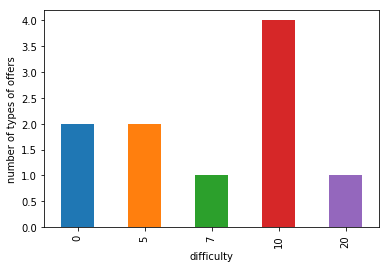

In [9]:
portfolio.groupby('difficulty')['id'].count().plot(kind='bar')
plt.xlabel('difficulty')
plt.ylabel('number of types of offers');

In [10]:
# what are the offer types?
print('there are {} types of offers'.format(portfolio['offer_type'].nunique()))
print('the types of offers are: {}'.format(portfolio['offer_type'].unique().tolist()))

there are 3 types of offers
the types of offers are: ['bogo', 'informational', 'discount']


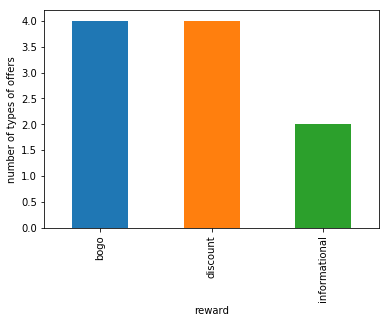

In [11]:
portfolio.groupby('offer_type')['id'].count().plot(kind='bar')
plt.xlabel('reward')
plt.ylabel('number of types of offers');

In [12]:
# what are the reward thresholds?
print('there are {} reward thresholds'.format(portfolio['reward'].nunique()))
print('the reward thresholds are: {}'.format(portfolio['reward'].unique().tolist()))

there are 5 reward thresholds
the reward thresholds are: [10, 0, 5, 3, 2]


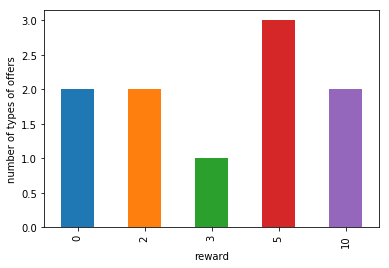

In [13]:
portfolio.groupby('reward')['id'].count().plot(kind='bar')
plt.xlabel('reward')
plt.ylabel('number of types of offers');

In [14]:
# what are the durations?
print('there are {} durations'.format(portfolio['duration'].nunique()))
print('the durations are: {}'.format(portfolio['duration'].unique().tolist()))

there are 5 durations
the durations are: [7, 5, 4, 10, 3]


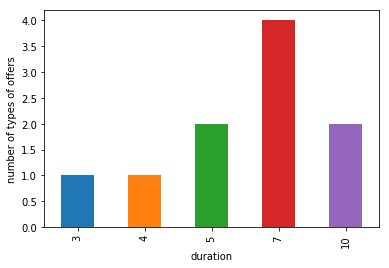

In [15]:
portfolio.groupby('duration')['id'].count().plot(kind='bar')
plt.xlabel('duration')
plt.ylabel('number of types of offers');

In [16]:
# get a list of the channels
channel_list = set()
for channels in portfolio['channels']:
    channel_list.update(channels)

channel_list = list(channel_list)
channel_list

['social', 'email', 'mobile', 'web']

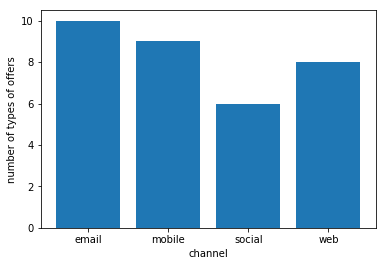

In [17]:
# how many types of offers carry each channel?
channel_freq = dict.fromkeys(channel_list, 0)
for channel in channel_list:
    for offer in portfolio['channels']:
        if channel in offer:
            channel_freq[channel] = channel_freq[channel] + 1
    
plt.bar(channel_freq.keys(), channel_freq.values())
plt.xlabel('channel')
plt.ylabel('number of types of offers');

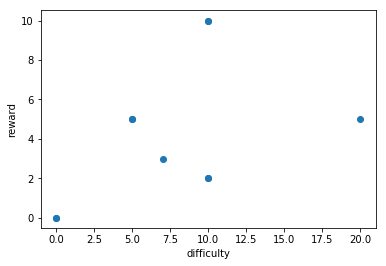

In [18]:
# relationship between difficulty and reward threshold
plt.scatter(portfolio['difficulty'], portfolio['reward'])
plt.xlabel('difficulty')
plt.ylabel('reward');

Roughly speaking, higher difficulty translates into higher reward.

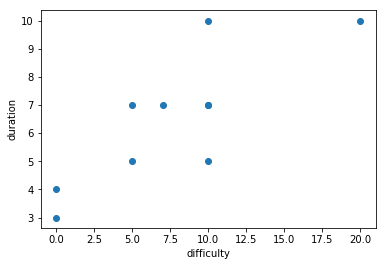

In [19]:
# relationship between difficulty and duration
plt.scatter(portfolio['difficulty'], portfolio['duration'])
plt.xlabel('difficulty')
plt.ylabel('duration');

Roughly speaking, higher difficulty is associated with longer duration.

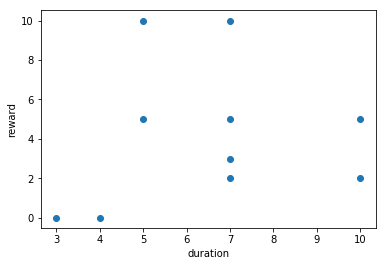

In [20]:
# relationship between duration and reward threshold
plt.scatter(portfolio['duration'], portfolio['reward'])
plt.xlabel('duration')
plt.ylabel('reward');

There is no strong relationship between reward and duration.

In [21]:
# add categorical columns for offer types
portfolio['bogo'] = portfolio['offer_type'].apply(lambda ot: 1 if ot == 'bogo' else 0)
portfolio['discount'] = portfolio['offer_type'].apply(lambda ot: 1 if ot == 'discount' else 0)
portfolio['informational'] = portfolio['offer_type'].apply(lambda ot: 1 if ot == 'informational' else 0)

In [22]:
# add categorical columns for channels
portfolio['email'] = portfolio['channels'].apply(lambda channels: 1 if 'email' in channels else 0)
portfolio['mobile'] = portfolio['channels'].apply(lambda channels: 1 if 'mobile' in channels else 0)
portfolio['social'] = portfolio['channels'].apply(lambda channels: 1 if 'social' in channels else 0)
portfolio['web'] = portfolio['channels'].apply(lambda channels: 1 if 'web' in channels else 0)

In [23]:
# add column containing summary of offer parameters type_diff_dur_rew
portfolio['type_diff_dur_rew'] = portfolio['offer_type'].str[0] + '-' + portfolio['difficulty'].astype('str') + '-' + portfolio['duration'].astype('str') + '-' + portfolio['reward'].astype('str')

In [24]:
portfolio

,channels,difficulty,duration,id,offer_type,reward,bogo,discount,informational,email,mobile,social,web,type_diff_dur_rew
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,0,0,1,1,1,0,b-10-7-10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,0,0,1,1,1,1,b-10-5-10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0,0,0,1,1,1,0,1,i-0-4-0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,0,0,1,1,0,1,b-5-7-5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,0,1,0,1,0,0,1,d-20-10-5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,0,1,0,1,1,1,1,d-7-7-3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2,0,1,0,1,1,1,1,d-10-10-2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0,0,0,1,1,1,1,0,i-0-3-0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,1,0,0,1,1,1,1,b-5-5-5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2,0,1,0,1,1,0,1,d-10-7-2


In [25]:
# portfolio data frame for README file
portfolio[['id','offer_type','difficulty','duration','reward','type_diff_dur_rew']].sort_values(['offer_type','difficulty','duration','reward'])

,id,offer_type,difficulty,duration,reward,type_diff_dur_rew
8,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,5,5,b-5-5-5
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,7,5,b-5-7-5
1,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,5,10,b-10-5-10
0,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,7,10,b-10-7-10
5,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,7,7,3,d-7-7-3
9,2906b810c7d4411798c6938adc9daaa5,discount,10,7,2,d-10-7-2
6,fafdcd668e3743c1bb461111dcafc2a4,discount,10,10,2,d-10-10-2
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,20,10,5,d-20-10-5
7,5a8bc65990b245e5a138643cd4eb9837,informational,0,3,0,i-0-3-0
2,3f207df678b143eea3cee63160fa8bed,informational,0,4,0,i-0-4-0


## Examine profile data frame

In [26]:
profile.shape

(17000, 5)

In [27]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [28]:
# missing age has been coded as 118. replace 118s by nan. presumably, no customer is 118 years old.
profile['age'] = np.where(profile['age'] == 118, np.nan, profile['age'])

In [29]:
profile.head()

,age,became_member_on,gender,id,income
0,NaN,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55.0,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,NaN,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75.0,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,NaN,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [30]:
profile.describe()

,age,became_member_on,income
count,14825.000000,1.700000e+04,14825.000000
mean,54.393524,2.016703e+07,65404.991568
std,17.383705,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,42.000000,2.016053e+07,49000.000000
50%,55.000000,2.017080e+07,64000.000000
75%,66.000000,2.017123e+07,80000.000000
max,101.000000,2.018073e+07,120000.000000


Highest income is $120,000. Why aren't there customers with higher incomes in the data set? Were they not targeted?

Age and income may have been input when the customer became a member, and may have not been updated since then.

It will be assumed that the customer entered their date of birth at the time of becoming a member, and Starbuck's system has calculated the age as of the promotion date. If not, the age is incorrect, is a souce of error, and would have to updated as of the promotion date.

If income has not been updated, income could be significantly different, especially for the earliest members, and a source of error in the analysis. It will be assumed that income data is current as of the promotion date.

In [31]:
# how many missing values in each column?
print('there are {} missing values for age'.format(profile.shape[0] - profile['age'].count()))
print('there are {} missing values for became_member_on'.format(profile.shape[0] - profile['became_member_on'].count()))
print('there are {} missing values for income'.format(profile.shape[0] - profile['income'].count()))
print('there are {} missing values for gender'.format(profile[profile['gender'].isna()]['id'].count()))

there are 2175 missing values for age
there are 0 missing values for became_member_on
there are 2175 missing values for income
there are 2175 missing values for gender


In [32]:
# are the missing gender, age and income data in the same rows?
print('{} rows are missing gender, age and income'.format(profile[(profile['gender'].isna()) & 
                                                                  (profile['age'].isna()) & 
                                                                  (profile['income'].isna())]['became_member_on'].count()))

2175 rows are missing gender, age and income


Gender, age and income are all missing together.

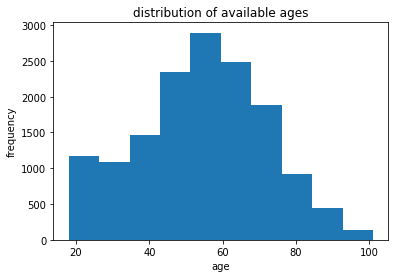

In [33]:
# plot the distribution of available ages
plt.hist(profile['age'].dropna())
plt.title('distribution of available ages')
plt.xlabel('age')
plt.ylabel('frequency');

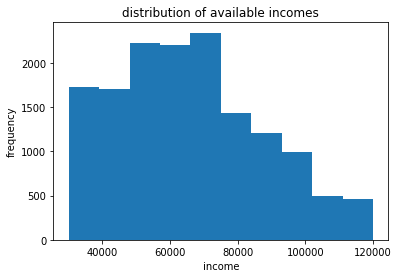

In [34]:
# plot the distribution of available incomes
plt.hist(profile['income'].dropna())
plt.title('distribution of available incomes')
plt.xlabel('income')
plt.ylabel('frequency');

### The age distribution is skewed towards younger customers. If older customers are more reluctant to provide their age, the missing data could have a bias towards older customers. Or, is it that younger customers are more reluctant to provide age and income information? This could affect how we fill in missing age and income values.

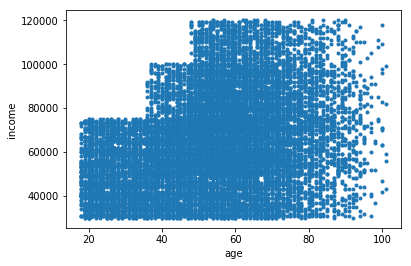

In [35]:
# plot the available incomes against age
plt.scatter(profile['age'].dropna(), profile['income'].dropna(), marker='.')
plt.xlabel('age')
plt.ylabel('income');

The stair-step behavior is odd. What is causing it?

In [36]:
# create columns for year, month and day became member
profile['became_member_day'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d').dt.day
profile['became_member_month'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d').dt.month
profile['became_member_year'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d').dt.year

In [37]:
profile.head()

,age,became_member_on,gender,id,income,became_member_day,became_member_month,became_member_year
0,NaN,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN,12,2,2017
1,55.0,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0,15,7,2017
2,NaN,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN,12,7,2018
3,75.0,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,9,5,2017
4,NaN,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN,4,8,2017


In [38]:
profile.groupby(['became_member_year'])['id'].count()

became_member_year
2013     286
2014     691
2015    1830
2016    3526
2017    6469
2018    4198
Name: id, dtype: int64

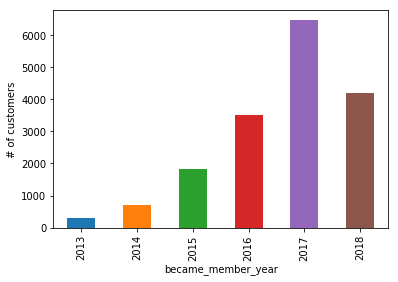

In [39]:
# plot distribution of year in which customers became a member
profile.groupby(['became_member_year'])['id'].count().plot(kind='bar')
plt.ylabel('# of customers');

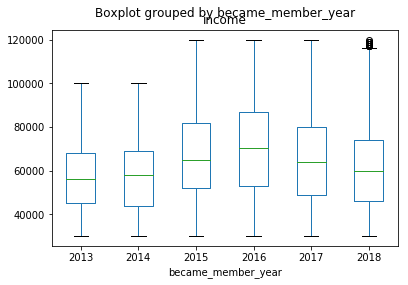

In [40]:
# make a boxplot of income distribution by became_member_year
profile.boxplot(by='became_member_year', column='income', grid=False);

Odd that maximum income in 2013-joiners and 2014-joiners is 100K and jumps to 120K from 2015 onward.

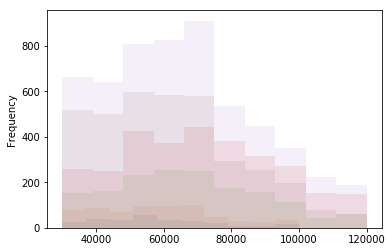

In [41]:
profile.groupby('became_member_year')['income'].plot.hist(alpha=0.1);

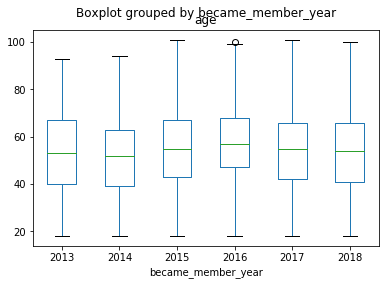

In [42]:
# make a boxplot of age distribution by became_member_year
profile.boxplot(by='became_member_year', column='age', grid=False);

Earlier joiners appear to be younger than later joiners, on average. Some 100-year-olds joined from 2015 onwards.

In [43]:
# get statistics for the gender column
profile['gender'].describe()

count     14825
unique        3
top           M
freq       8484
Name: gender, dtype: object

In [44]:
# what are the values for gender?
print('the values for gender are {}'.format(profile['gender'].unique().tolist()))

the values for gender are [None, 'F', 'M', 'O']


In [45]:
# how many values of each type?
profile.groupby('gender')['id'].count()

gender
F    6129
M    8484
O     212
Name: id, dtype: int64

In [46]:
# what is the precentage of O gender?
print('percentage of O gender: {:.1f}%'.format(100 *
    profile[profile['gender'] == 'O']['id'].count() / profile.groupby('gender')['id'].count().sum()))

percentage of O gender: 1.4%


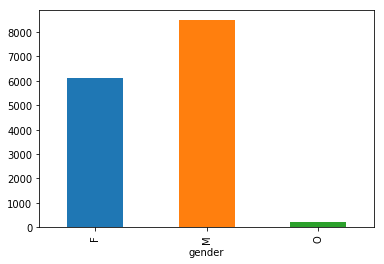

In [47]:
# plot gender distribution
profile.groupby('gender')['id'].count().plot.bar();

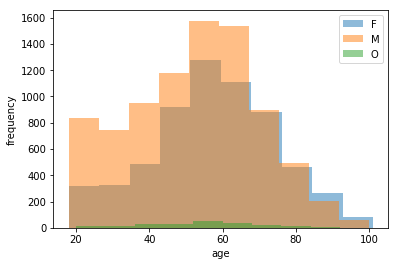

In [48]:
# plot age by gender
profile.groupby('gender')['age'].plot.hist(alpha=0.5)
plt.xlabel('age')
plt.ylabel('frequency')
plt.legend();

There are more males than females in the younger age groups.

As a gender, females are skewed toward higher ages, compared to males.

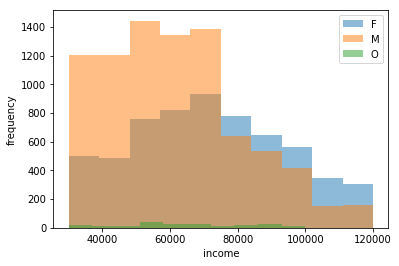

In [49]:
# plot income by gender
profile.groupby('gender')['income'].plot.hist(alpha=0.5)
plt.xlabel('income')
plt.ylabel('frequency')
plt.legend();

There are more males than females in the lower income groups.

Within gender, females are skewed towards higher income compared to males.

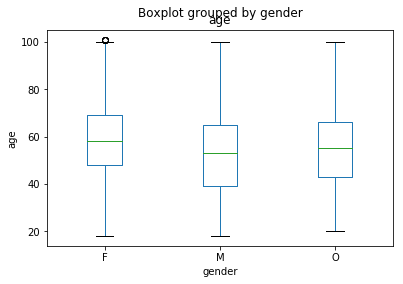

In [50]:
# make a boxplot of age distribution by gender
profile.boxplot(by='gender', column='age', grid=False)
plt.ylabel('age');

Male ages are skewed younger than female ages. Other gender ages are also skewed younger than female ages, and are roughly comparable to male ages.

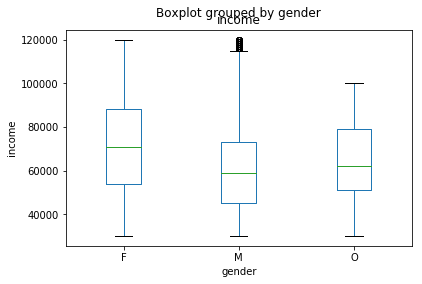

In [51]:
# make a boxplot of income distribution by gender
profile.boxplot(by='gender', column='income', grid=False)
plt.ylabel('income');

Male incomes are skewed lower than female incomes. Other gender incomes are also skewed lower than female incomes, but higher than male incomes.

Is there any commonality between the rows that are missing age, income and gender? The only remaining column that may indicate commonality is, perhaps, 'became_member_year'

In [52]:
# what fraction of each year's joiners have missing data?
[100*x/y for x,y in zip(profile[profile['age'].isna()].groupby('became_member_year')['id'].count().values, profile.groupby('became_member_year')['id'].count().values)]

[4.1958041958041958,
 4.1968162083936322,
 12.73224043715847,
 14.237095859330687,
 13.448755603648168,
 12.601238685088138]

Those who became members in 2013 and 2014 have about 4% missing data. Those who joined after 2014 have about 12%-14% missing data. I don't know what to make of this patters.

### Check if the profile data fall into any groups. The relevant customer attributes are age, income, gender and became_member_year. So far, the exploratory work has not indicated any strong relationships, but let's double check.

Two methods will be used - PCA and K-Means. We are looking for grouping/clustering tendency. This info will not (yet) be used to make any predictions, so the entire profile data set will be used (less the missing rows) without dividing it into a training set and a test set.

In [53]:
# drop rows with missing data. if data is missing, age, gender and income are all missing, as observed earlier.
df_profile_groups = profile.dropna(axis=0).copy()

# delete the became_member_on, became_member_day and became_member_month columns
df_profile_groups.drop(columns=['became_member_on', 'became_member_day', 'became_member_month'], inplace = True)

# create categorical columns for gender
df_profile_groups['M'] = df_profile_groups['gender'].apply(lambda g: 1 if g == 'M' else 0)
df_profile_groups['F'] = df_profile_groups['gender'].apply(lambda g: 1 if g == 'F' else 0)
df_profile_groups['O'] = df_profile_groups['gender'].apply(lambda g: 1 if g == 'O' else 0)

df_profile_groups.head()

,age,gender,id,income,became_member_year,M,F,O
1,55.0,F,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,0,1,0
3,75.0,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017,0,1,0
5,68.0,M,e2127556f4f64592b11af22de27a7932,70000.0,2018,1,0,0
8,65.0,M,389bc3fa690240e798340f5a15918d5c,53000.0,2018,1,0,0
12,58.0,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,2017,1,0,0


### Try PCA first.

In [54]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [55]:
sc = StandardScaler(with_mean=True, with_std=True, copy=True)
pca = PCA(copy=True, random_state=99)

In [56]:
features = ['age','income','M','F','O','became_member_year']
n_features = len(features)
X = df_profile_groups[features]
X_scaled = sc.fit_transform(X)
pca.fit(X_scaled)
scores = pca.transform(X_scaled)

In [57]:
pca.singular_values_

array([  1.78396683e+02,   1.30448476e+02,   1.23372783e+02,
         1.21255738e+02,   1.00915911e+02,   4.22710499e-13])

In [58]:
def plot_singular_values(sv):
    '''
    make a bar chart showing the singular values. xtick text is created within the function.
    Input:
        sv (array) singular values
    Returns: none
    '''
    xticklabels = []
    for i in range(len(sv)):
        xticklabels.append('PC' + str(i))
        
    plt.bar(xticklabels, sv)
    plt.ylabel('singular value');
    
    return

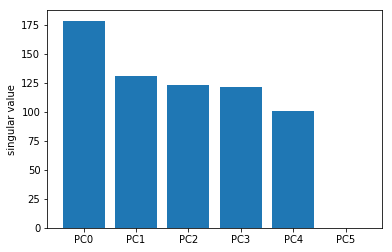

In [59]:
# make a bar chart of the singular values
plot_singular_values(pca.singular_values_)

The first principal component explains more of the variance that any of the other principal components. Each of the next four principal components also accounts for a significant portion of the variance in the data. The last principal component has a negligible contribution.

In [60]:
# for the components,
# rows are components (transformed variables)
# columns are features (original variables)
pca.components_

array([[  2.57087785e-01,   3.23882228e-01,  -6.44386228e-01,
          6.42990907e-01,   1.82767790e-02,   1.10307886e-03],
       [ -6.58645749e-01,  -5.79552348e-01,  -2.93849177e-01,
          2.55742883e-01,   1.63752262e-01,   2.27460520e-01],
       [  1.59873827e-01,   8.73603490e-02,  -4.72348699e-02,
         -1.82637110e-01,   9.54376615e-01,   1.42780804e-01],
       [ -1.61397352e-01,  -9.09319154e-02,  -7.50531080e-02,
          3.16064077e-02,   1.81662523e-01,  -9.62314437e-01],
       [  6.69688661e-01,  -7.37101712e-01,  -4.84410730e-02,
          5.59049925e-02,  -3.00199157e-02,  -4.27207459e-02],
       [  1.44116142e-15,  -2.26679073e-15,   6.98719122e-01,
          6.95469356e-01,   1.67672193e-01,   5.67337692e-17]])

In [61]:
def make_clustered_bar_chart(data, group_labels, series_labels, n_series):
    '''
    make a clustered bar plot. groups are labeled along the x-axis. series are subgroups with labels in the legend.
    Inputs:
        data: square 2-d array of data. rows are components, columns are variables
        group_labels: labels for main groups along x-axis. all groups are plotted.
        series_labels: labels for sugroups within groups
        n_series: number of series (subgroups) to plot. the first n_series are plotted.
    Return: none
    '''
    n_groups = data.shape[1]
    if n_series > data.shape[0]:
        print('The maximum number of series ({}) in the data will be plotted, though request is for {} series.'
              .format(data.shape[0], n_series))
        n_series = data.shape[0]
    width = 0.7 / n_series # width of bar for each series
    x0 = -(n_series - 1) / 2 # offset of first series's bar from tick at the center of the group
    x = np.arange(n_groups)
    
    plt.figure(figsize=(15,5))
    for i in range(n_series):
        plt.bar(x + x0 * width, data[i], width=width, label=series_labels[i])
        x0 += 1
    plt.xticks(x, group_labels)
    plt.legend()
    plt.axhline(linewidth=1, color='black');

In [62]:
def make_sorted_clustered_bar_chart(data, group_labels, series_labels, n_series, descending=True):
    '''
    make a clustered bar plot. within a group, series are arranged in the specified order (descending order by default)
    groups are labeled along the x-axis. series are subgroups with labels in the legend.
    Inputs:
        data: square 2-d array of data. rows are components, columns are variables
        group_labels: labels for main groups along x-axis. all groups are plotted.
        series_labels: labels for sugroups within groups
        n_series: number of series (subgroups) to plot. the first n_series are plotted.
    Return: none
    '''
    n_groups = data.shape[1]
    if n_series > data.shape[0]:
        print('The maximum number of series ({}) in the data will be plotted, though request is for {} series.'
              .format(data.shape[0], n_series))
        n_series = data.shape[0]
    width = 0.7 / n_series # width of bar for each series
    x0 = -(n_series - 1) / 2 # offset of first series's bar from tick at the center of the group
    x = np.arange(n_groups)
    
    # make an array of the x-coordinates of each series in each group if there were no sorting
    x_def = list()
    for i in range(n_series):
        x_def.append(x + x0 * width)
        x0 += 1
    x_def = np.array(x_def)
    
    # for each group, rearrange the x-coordinate for each bar so that the series are sorted in the desired order
    for i in range(n_groups):
        d = data.transpose()[i]
        x_sort = x_def.transpose()[i]
        ix = range(len(d))
        zipped_lists = zip(d, ix)
        sorted_zipped_lists = sorted(zipped_lists, reverse=descending)
        ix = np.array(sorted_zipped_lists).transpose()[1]
        zipped_lists = zip(ix,x_sort)
        sorted_zipped_lists = sorted(zipped_lists)
        x_sort = np.array(sorted_zipped_lists).transpose()[1]
        x_def.transpose()[i] = x_sort
    
    plt.figure(figsize=(15,5))
    for i in range(n_series):
        plt.bar(x_def[i], data[i], width=width, label=series_labels[i])
    plt.xticks(x, group_labels)
    plt.legend()
    plt.axhline(linewidth=1, color='black');

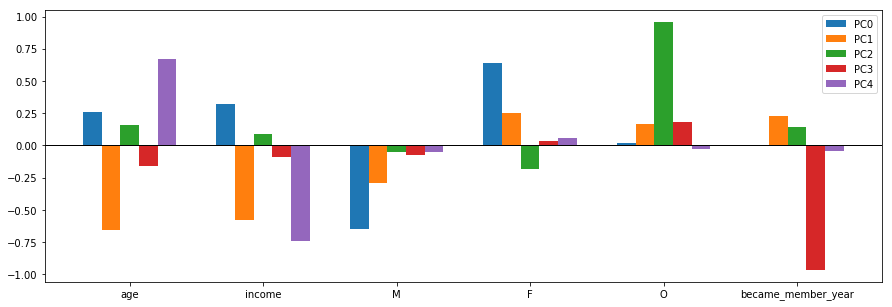

In [63]:
# make bar chart showing the loading vectors for the first 5 principal components
make_clustered_bar_chart(pca.components_, features, 
                         ['PC' + str(i) for i in range(pca.components_.shape[1])], 
                         pca.components_.shape[1]-1)

**First principal component** (PC0; single-largest explaination of variance): The largest blue bars are for the M and F genders. The opposte disrections of these two bars indicate that a person cannot be M and F. The O gender is not highlighted, perhaps because a small proportion of customers identified as gender O. This the primary disctinction represented by PC0. To a smaller extent, it shows that customers of F gender have slightly above-average age and income whereas M gender customers have slightly below-average age and income.

**Second principal component** (PC1; lower strength than PC0; orange bars): The largest orange bars show a positive correlation between age and gender. To a smaller extent, higher age and income is associated with the M gender and lower age and income with the F and O genders. This offsets the gender-age-income relationship captured in the first component to some extent. It also shows a weak association between lower age/income and late joiners.

**Third principal component** (PC2; comparable strength to PC1; green bars): Primarily represents the O gender, with a slight association with higher age, higher income and late joiners.

**Fourth principal component** (PC3; comparable strength to PC1 and PC2; red bars): Primarily depends on the year in which the customer joined. This has very weak associations with the other features.

**Fifth principal component** (PC4; slightly lower strength that PC1-PC3; purple bars): Captures customers with above-average age and below-average income and vice versa. The customers do not have any appreciable association with gender or year of joining.

In [64]:
colors = {'M':'blue', 'F':'red', 'O':'green'}

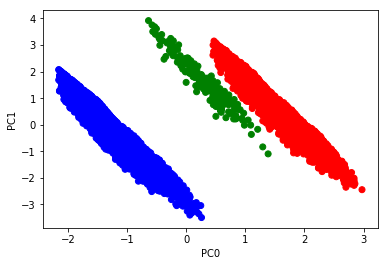

In [65]:
plt.scatter(scores[:,0], scores[:,1], c=df_profile_groups['gender'].map(colors))
plt.xlabel('PC0')
plt.ylabel('PC1');

The above scatter plot of the scores (transformed feature variables) for PC0 and PC1 shows a distinct separation between M gender (blue dots) and F gender (red dots) in the horizontal direction, as indicated by the bar plot of the components (discussed above). Within each gender, the high age/high income customers are at the lower right of the cluster, while low age/low income customers are at the upper left of the cluster).

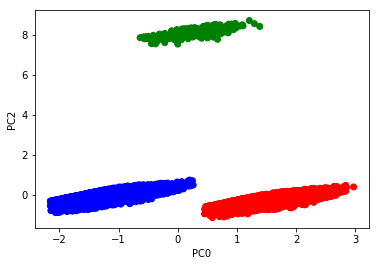

In [66]:
plt.scatter(scores[:,0], scores[:,2], c=df_profile_groups['gender'].map(colors))
plt.xlabel('PC0')
plt.ylabel('PC2');

This scatter plot of the PC0 and PC2 scores shows a distinct separation of the O gender along the PC2 (vertical) dimension, as discussed above for PC2.

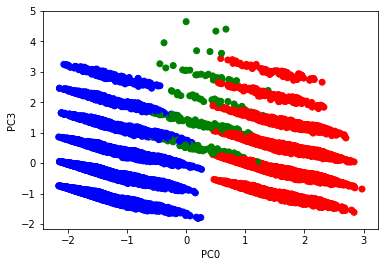

In [67]:
plt.scatter(scores[:,0], scores[:,3], c=df_profile_groups['gender'].map(colors))
plt.xlabel('PC0')
plt.ylabel('PC3');

Scatter plot of PC3 versus PC0 scores: as discussed in the bar plot, clusters form for each of the became_member_year along the PC3 (vertical) direction within each gender.

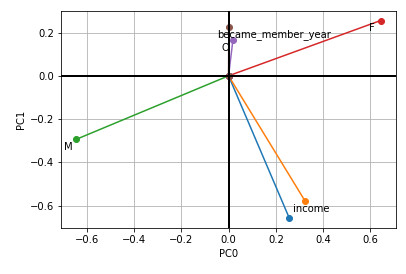

In [68]:
for i in range(pca.components_[0].shape[0]):
    plt.plot([0,pca.components_[0][i]], [0,pca.components_[1][i]], '-o')

for i, txt in enumerate(features):
    plt.annotate(txt, (pca.components_[0][i]-0.05, pca.components_[1][i]-0.05))
    
plt.xlabel('PC0')
plt.ylabel('PC1')
plt.grid()
plt.axhline(linewidth=2, color='black')
plt.axvline(linewidth=2, color='black');

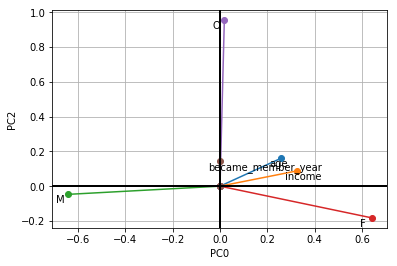

In [69]:
for i in range(pca.components_[0].shape[0]):
    plt.plot([0,pca.components_[0][i]], [0,pca.components_[2][i]], '-o')

for i, txt in enumerate(features):
    plt.annotate(txt, (pca.components_[0][i]-0.05, pca.components_[2][i]-0.05))
    
plt.xlabel('PC0')
plt.ylabel('PC2')
plt.grid()
plt.axhline(linewidth=2, color='black')
plt.axvline(linewidth=2, color='black');

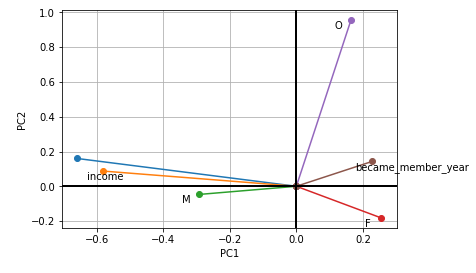

In [70]:
for i in range(pca.components_[1].shape[0]):
    plt.plot([0,pca.components_[1][i]], [0,pca.components_[2][i]], '-o')

for i, txt in enumerate(features):
    plt.annotate(txt, (pca.components_[1][i]-0.05, pca.components_[2][i]-0.05))
    
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid()
plt.axhline(linewidth=2, color='black')
plt.axvline(linewidth=2, color='black');

The above scatter plots summarize the PCA findings:
1. M and F genders always on opposite sides of the origin, i.e., these groups are exclusive;
2. Age and income are always close together, implying high positive correlation between the two;
3. O gender is orthogonal to M and F (if there were more customers of O gender, the three might have formed an equilateral triangle;
4. Age and income are on a line that is perpendicular to the plane formed by M, F and O, which means that age and income are largely unrelated to gender, though the first two scatter plots show that age/income are closer to F gender.

### Try K-Means clustering to see if it provides any additional insight.

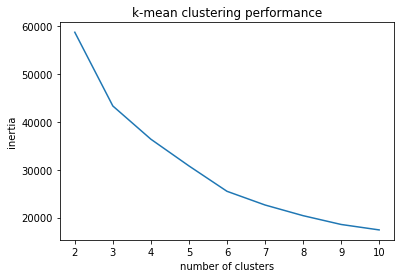

In [71]:
# try the KMeans algorithm for different numbers of clusters
# X_scaled is available from the PCA analysis

km_results = []
km_fit = []

for n_clusters in range(2,11):
    km = KMeans(n_clusters=n_clusters, random_state=99)
    km.fit(X_scaled)
    km_fit.append(km)
    km_transform = km.transform(X_scaled)
    inertia = km.inertia_
    km_results.append([n_clusters, inertia, km.cluster_centers_])

km_results = pd.DataFrame(km_results)
plt.plot(km_results[0], km_results[1])
plt.xlabel('number of clusters')
plt.ylabel('inertia')
plt.title('k-mean clustering performance');

The performance improves as the number of clusters increases. There is no distict "elbow" in the above plot.

Let us examine how the clusters are centered. Keep in mind that the variables are in the following order: **age, income, M, F, O, year_became_member**.

**Two clusters** (see cell below): the clusters are centered as follows:
1. M gender, slightly-below-average age and income;
2. F gender, slightly-above average age and income.

In [72]:
# cluster centers using two clusters
km_results.iloc[0][2]

array([[ 0.17524539,  0.26083167, -1.15670191,  1.12325394,  0.16115402,
         0.01401859],
       [-0.13097961, -0.19494738,  0.86452697, -0.83952773, -0.12044762,
        -0.01047759]])

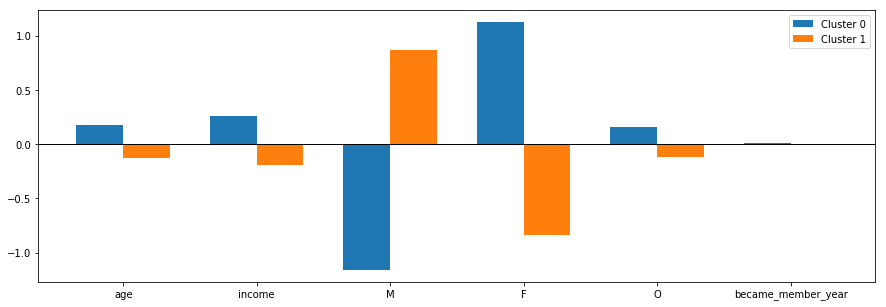

In [73]:
make_clustered_bar_chart(km_results.iloc[0][2], features, 
                         ['Cluster ' + str(i) for i in range(km_results.iloc[0][2].shape[0])], 
                         km_results.iloc[0][2].shape[0])

**Three clusters** (see cell below): the clusters are centered as follows:
1. M gender, slightly-below-average age and income;
2. F gender, slightly-above-average age and income;
3. O gender.

In [74]:
# cluster centers using three clusters
km_results.iloc[1][2]

array([[ -1.30979613e-01,  -1.94947384e-01,   8.64526971e-01,
         -8.39527729e-01,  -1.20447624e-01,  -1.04775934e-02],
       [  1.81292309e-01,   2.73244643e-01,  -1.15670191e+00,
          1.19114589e+00,  -1.20447624e-01,   1.15725488e-02],
       [  4.26790167e-04,  -9.80321224e-02,  -1.15670191e+00,
         -8.39527729e-01,   8.30236384e+00,   8.47346723e-02]])

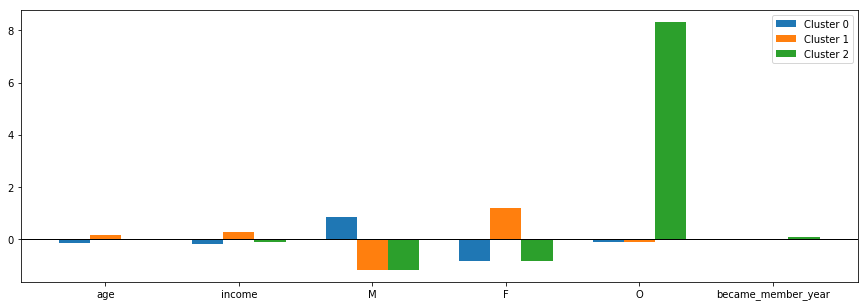

In [75]:
make_clustered_bar_chart(km_results.iloc[1][2], features, 
                         ['Cluster ' + str(i) for i in range(km_results.iloc[1][2].shape[0])], 
                         km_results.iloc[1][2].shape[0])

**Four clusters** (cell below): the clusters are centered as follows:
1. M gender, slightly-below-average age and income;
2. M gender, slightly-above-average age and income;
3. F gender, slightly-above-average age and income;
4. O gender, average age and income.

In [76]:
# cluster centers using four clusters
km_results.iloc[2][2]

array([[ -8.60971803e-01,  -7.21695787e-01,   8.64526971e-01,
         -8.39527729e-01,  -1.20447624e-01,   2.30056342e-01],
       [  5.57547147e-01,   3.01880358e-01,   8.64526971e-01,
         -8.39527729e-01,  -1.20447624e-01,  -2.37348584e-01],
       [  1.81292309e-01,   2.73244643e-01,  -1.15670191e+00,
          1.19114589e+00,  -1.20447624e-01,   1.15725488e-02],
       [  4.26790167e-04,  -9.80321224e-02,  -1.15670191e+00,
         -8.39527729e-01,   8.30236384e+00,   8.47346723e-02]])

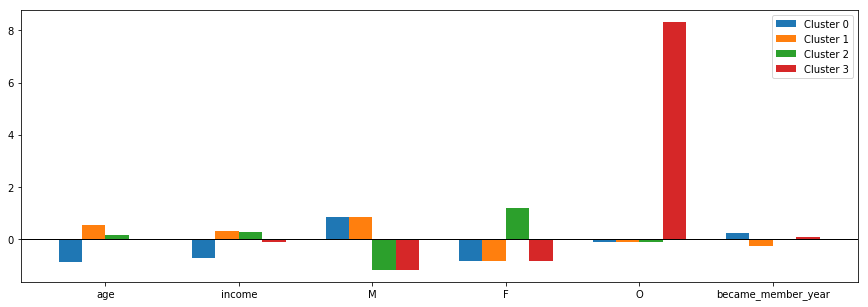

In [77]:
make_clustered_bar_chart(km_results.iloc[2][2], features, 
                         ['Cluster ' + str(i) for i in range(km_results.iloc[2][2].shape[0])], 
                         km_results.iloc[2][2].shape[0])

**Five clusters** (cell below), the clusters are centered as follows:
1. F gender, above-average age and income;
2. M gender, slightly-below-average age and income;
3. F gender, slightly-below-average age and income;
4. O gender, average age and income;
5. M gender, slightly-below-average age and income.

In [78]:
# cluster centers using five clusters
km_results.iloc[3][2]

array([[  6.75151807e-01,   9.90840805e-01,  -1.15670191e+00,
          1.19114589e+00,  -1.20447624e-01,  -2.59578765e-02],
       [ -1.71584133e-01,  -2.51472938e-01,   8.64526971e-01,
         -8.39527729e-01,  -1.20447624e-01,   6.75720152e-01],
       [ -4.05871360e-01,  -5.79925937e-01,  -1.15670191e+00,
          1.19114589e+00,  -1.20447624e-01,   5.61935437e-02],
       [  4.26790167e-04,  -9.80321224e-02,  -1.15670191e+00,
         -8.39527729e-01,   8.30236384e+00,   8.47346723e-02],
       [ -6.06376768e-02,  -9.70243722e-02,   8.64526971e-01,
         -8.39527729e-01,  -1.20447624e-01,  -1.19922403e+00]])

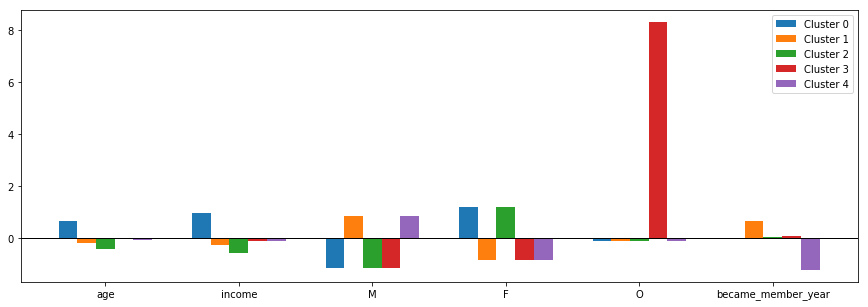

In [79]:
make_clustered_bar_chart(km_results.iloc[3][2], features, 
                         ['Cluster ' + str(i) for i in range(km_results.iloc[3][2].shape[0])], 
                         km_results.iloc[3][2].shape[0])

As more clusters are added (for example, see the cell below for six clusters), the clusters remain differentiated primarily by gender, with differentiation by age and income becoming more granular. Year of joining is a small factor.

In [80]:
# cluster centers using six clusters
km_results.iloc[4][2]

array([[ -7.95520293e-01,  -7.40831903e-01,   8.64526971e-01,
         -8.39527729e-01,  -1.20447624e-01,   5.10028196e-01],
       [  6.79410532e-01,   9.90863935e-01,  -1.15670191e+00,
          1.19114589e+00,  -1.20447624e-01,  -3.67596896e-02],
       [  4.26790167e-04,  -9.80321224e-02,  -1.15670191e+00,
         -8.39527729e-01,   8.30236384e+00,   8.47346723e-02],
       [ -2.42979265e-01,  -3.40261704e-01,   8.05808249e-01,
         -7.80534629e-01,  -1.20447624e-01,  -1.89310626e+00],
       [  6.13041771e-01,   4.35703030e-01,   8.64526971e-01,
         -8.39527729e-01,  -1.20447624e-01,   2.60269375e-01],
       [ -4.09111315e-01,  -5.72227873e-01,  -1.15670191e+00,
          1.19114589e+00,  -1.20447624e-01,   1.18836204e-01]])

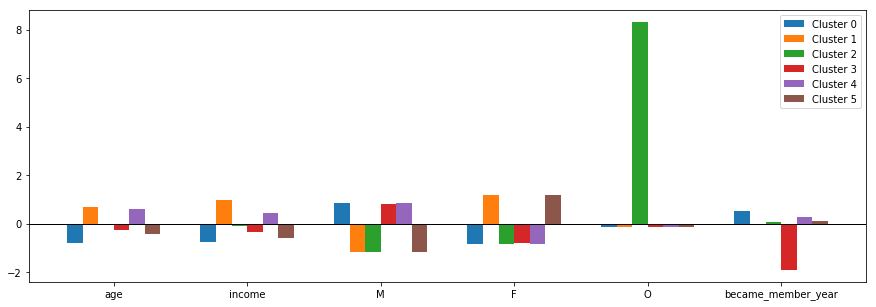

In [81]:
make_clustered_bar_chart(km_results.iloc[4][2], features, 
                         ['Cluster ' + str(i) for i in range(km_results.iloc[4][2].shape[0])], 
                         km_results.iloc[4][2].shape[0])

### Conclusion of clustering analysis:
PCA and K-Means are in agreement. Gender is the primary point of differentiation. Over all, M-gender has below-average age and income while F-gender has above average age and income. O-gender age and income are at the average for the data set.

K-Means is able to create finer distinctions as more clusters are added. These are around creating sub-groups within the three genders based on age and income.

We will pause the clustering analysis here, but it pick up later to see whether there are any relationships between clusters and customer behavior.

In [82]:
km_results

,0,1,2
0,2,58760.928055,"[[0.175245393289, 0.260831668263, -1.156701911..."
1,3,43342.661063,"[[-0.130979613254, -0.194947384307, 0.86452697..."
2,4,36395.119952,"[[-0.860971802566, -0.72169578745, 0.864526970..."
3,5,30811.017081,"[[0.675151807195, 0.99084080544, -1.1567019116..."
4,6,25502.670892,"[[-0.795520293477, -0.740831902881, 0.86452697..."
5,7,22639.503233,"[[0.594072257748, -0.648202935516, 0.864526970..."
6,8,20408.857614,"[[-1.15741806429, -0.644348367322, 0.864526970..."
7,9,18567.572890,"[[0.597904800784, -0.645864724495, 0.864526970..."
8,10,17427.874922,"[[-1.18775828027, -0.668518629462, 0.864526970..."


In [83]:
km_fit

[KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
     n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
     random_state=99, tol=0.0001, verbose=0),
 KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
     n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
     random_state=99, tol=0.0001, verbose=0),
 KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
     n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
     random_state=99, tol=0.0001, verbose=0),
 KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
     n_clusters=5, n_init=10, n_jobs=1, precompute_distances='auto',
     random_state=99, tol=0.0001, verbose=0),
 KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
     n_clusters=6, n_init=10, n_jobs=1, precompute_distances='auto',
     random_state=99, tol=0.0001, verbose=0),
 KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,

In [84]:
# Add the cluster number for each person that did not have missing data to the profile data frame 
# using the KMeans analysis with the specified number of clusters
# we will use five clusters from here on.
n_use_clusters = 5
cluster_pred = km_fit[list(km_results[0]).index(n_use_clusters)].predict(X_scaled)
profile = profile.merge(pd.DataFrame(cluster_pred, index=df_profile_groups.index, columns=['cluster']), 
                        left_index=True, right_index=True, how='outer')

In [85]:
list(km_results[0]).index(n_use_clusters)

3

In [86]:
profile.head(10)

,age,became_member_on,gender,id,income,became_member_day,became_member_month,became_member_year,cluster
0,NaN,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN,12,2,2017,NaN
1,55.0,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0,15,7,2017,0.0
2,NaN,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN,12,7,2018,NaN
3,75.0,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,9,5,2017,0.0
4,NaN,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN,4,8,2017,NaN
5,68.0,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0,26,4,2018,1.0
6,NaN,20170925,None,8ec6ce2a7e7949b1bf142def7d0e0586,NaN,25,9,2017,NaN
7,NaN,20171002,None,68617ca6246f4fbc85e91a2a49552598,NaN,2,10,2017,NaN
8,65.0,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0,9,2,2018,1.0
9,NaN,20161122,None,8974fc5686fe429db53ddde067b88302,NaN,22,11,2016,NaN


## Examine transcript data frame

In [87]:
transcript.shape

(306534, 4)

In [88]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [89]:
# how many missing items in each column?
transcript.isna().sum()

event     0
person    0
time      0
value     0
dtype: int64

There are no missing entries in this data set.

In [90]:
# how many types of events are there?
print('there are {} possible values for event'.format(transcript['event'].nunique()))
print('the possible values for event are {}'.format(transcript['event'].unique().tolist()))

there are 4 possible values for event
the possible values for event are ['offer received', 'offer viewed', 'transaction', 'offer completed']


In [91]:
# get statistics for the time column (time is in hours)
transcript['time'].describe()

count    306534.000000
mean        366.382940
std         200.326314
min           0.000000
25%         186.000000
50%         408.000000
75%         528.000000
max         714.000000
Name: time, dtype: float64

Logging of test data ended at t=714.

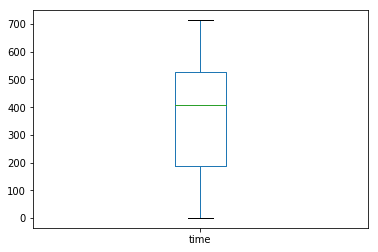

In [92]:
# visualize time distribution as a box plot
transcript.boxplot(column='time', grid=False);

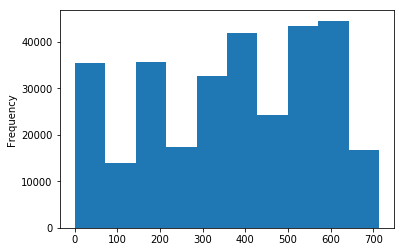

In [93]:
# visualize time distribution as a histogram
transcript['time'].plot.hist();

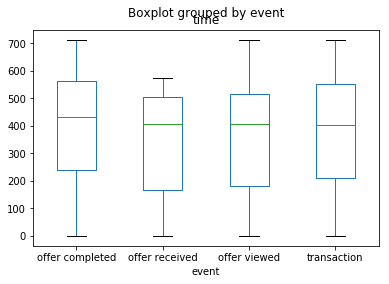

In [94]:
# view time statistics for each type of event
transcript.boxplot(by='event', column='time', grid=False);

In [95]:
# how many persons?
print('the number of unique persons in the transcript data set is {}'.format(transcript['person'].nunique()))
print('the number of unique persons in the profile data set is {}'.format(profile['id'].nunique()))

the number of unique persons in the transcript data set is 17000
the number of unique persons in the profile data set is 17000


In [96]:
# are the persons (ids) the same in both profile and transcripts data sets?
assert set(profile['id']) == set(transcript['person']), 'the ids are NOT the same in the two data sets'
print('the ids in the two data sets are the same')

the ids in the two data sets are the same


The number of persons in the profile and transcript data sets is the same.

In [97]:
# how many events for each person?
transcript.groupby('person')['event'].count().describe()

count    17000.000000
mean        18.031412
std          6.849595
min          1.000000
25%         13.000000
50%         17.000000
75%         23.000000
max         51.000000
Name: event, dtype: float64

Some persons had only one event. Some had as many as fifty one events. Half the persons (25th to 75th percentile) had between thirteen and twenty three events.

In [98]:
# distribution of how many offers each person received
transcript[transcript['event'] == 'offer received'].groupby('person')['event'].count().describe()

count    16994.000000
mean         4.488467
std          1.073047
min          1.000000
25%          4.000000
50%          5.000000
75%          5.000000
max          6.000000
Name: event, dtype: float64

16994 persons received offers, i.e., six persons did not receive any offers. Of the persons who received offers, most persons received at least five offers. Some received as many as six offers.

In [99]:
np.sort(transcript[transcript['event'] == 'offer received'].groupby('person')['event'].count().unique())

array([1, 2, 3, 4, 5, 6])

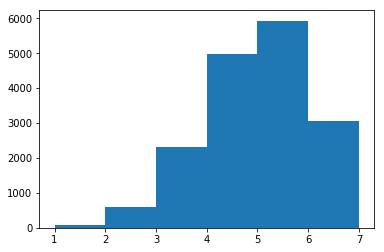

In [100]:
plt.hist(transcript[transcript['event'] == 'offer received'].groupby('person')['event'].count(), bins=range(1,8));

In [101]:
# how many events of each kind?
transcript.groupby('event')['event'].count()

event
offer completed     33579
offer received      76277
offer viewed        57725
transaction        138953
Name: event, dtype: int64

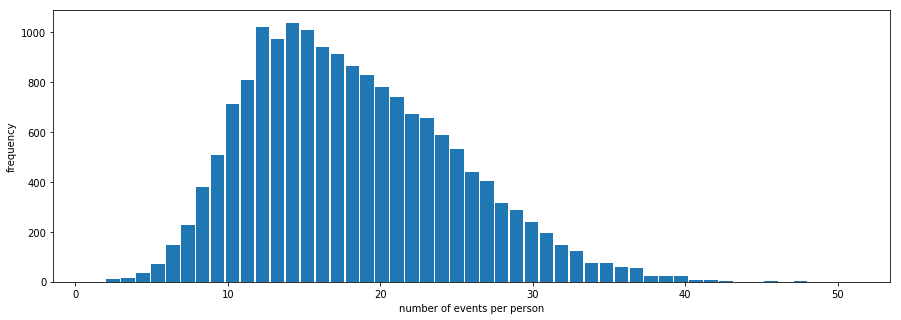

In [102]:
# plot a histogram of number of events per person
plt.figure(figsize=(15,5))
transcript.groupby('person')['event'].count().hist(grid=False, bins=51, rwidth=0.9)
plt.xlabel('number of events per person')
plt.ylabel('frequency');

In [103]:
def transcript_for_person(person=0):
    '''
    return the transcript entries for the specified person.
    Input:
        person: a 32-character string containing the person's alphanumeric person id or an integer
            giving the persons position in a list of persons as returned by the .unique() method applied
            to the 'person' column in the transcript data frame
    Output: data frame containing the specified persons transcript sorted by the 'time' column
    '''
    if len(str(person)) == 32:
        return transcript[transcript['person'] == person].sort_values('time')
    elif type(person) == int:
        return transcript[transcript['person'] == transcript['person'].unique()[person]].sort_values('time')

In [104]:
# pick an arbitrary person. what is the event history? sort by time earliest to latest.
transcript_for_person(0)

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
15561,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,6,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
47582,transaction,78afa995795e4d85b5d9ceeca43f5fef,132,{'amount': 19.89}
47583,offer completed,78afa995795e4d85b5d9ceeca43f5fef,132,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...
49502,transaction,78afa995795e4d85b5d9ceeca43f5fef,144,{'amount': 17.78}
53176,offer received,78afa995795e4d85b5d9ceeca43f5fef,168,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
85291,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,216,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
87134,transaction,78afa995795e4d85b5d9ceeca43f5fef,222,{'amount': 19.67}
92104,transaction,78afa995795e4d85b5d9ceeca43f5fef,240,{'amount': 29.72}
141566,transaction,78afa995795e4d85b5d9ceeca43f5fef,378,{'amount': 23.93}


In [105]:
# look at all the dicts in the value column and make a list of all possible keys
key_list = set()
for value in transcript['value']:
    key_list.update(value.keys())

key_list = list(key_list)
print('the keys are {}'.format(key_list))

the keys are ['offer_id', 'reward', 'offer id', 'amount']


Is the 'offer_id' key the same as the 'offer id' key? Let's look at a few dicts, some with 'offer_id' and some with 'offer id'.

In [106]:
transcript.loc[0]['value']

{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}

In [107]:
transcript.loc[15561]['value']

{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}

In [108]:
transcript.loc[163375]['value']

{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'}

In [109]:
transcript.loc[201572]['value']

{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}

The above dicts have a 'offer id' key. It is the only key/value pair in the dict.

In [110]:
transcript.loc[47583]['value']

{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9', 'reward': 5}

In [111]:
transcript.loc[218394]['value']

{'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd', 'reward': 10}

In [112]:
transcript.loc[218395]['value']

{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d', 'reward': 5}

The above dicts have a 'offer_id' key and also another key/value. The second key is 'reward'.

In [113]:
# Add the following columns to the transcript data frame:
# 'offer_id' - contains the offer id or offer_id if there is one, else na;
# 'amount' - contains the amount if there is an amount, else na;
# 'reward' - contains the reward if there is one, else na;



def get_offer_id(row):
    '''
    extracts the value corresponding to the 'offer_id' or 'offer id' key in the input dictionary
    in the 'value' column of the input row
    Input:
        row: a row of the transcript dataframe
    Output:
        value for 'offer id' or 'offer_id' key as str, if there is such a key, np.nan otherwise
    '''
    d = row['value']
    if 'offer id' in d:
        return str(d['offer id'])
    elif 'offer_id' in d:
        return str(d['offer_id'])
    else:
        return np.nan
    
def get_amount(row):
    '''
    extracts the value corresponding to the 'amount' key in the input dictionary in the 'value' column
    of the input row
    Input:
        row: a row of the transcript dataframe
    Output:
        value for 'amount' key, if there is such a key, np.nan otherwise
    '''
    d = row['value']
    if 'amount' in d:
        return d['amount']
    else:
        return np.nan
        
def get_reward(row):
    '''
    extracts the value corresponding to the 'amount' key in the input dictionary in the 'value' column
    of the input row
    Input:
        row: a row of the transcript dataframe
    Output:
        value for 'reward' key, if there is such a key, np.nan otherwise
    '''
    d = row['value']
    if 'reward' in d:
        return d['reward']
    else:
        return np.nan
    
transcript['id'] = transcript.apply(get_offer_id, axis=1)
transcript['amount'] = transcript.apply(get_amount, axis=1)
transcript['reward'] = transcript.apply(get_reward, axis=1)

In [114]:
transcript.head()

,event,person,time,value,id,amount,reward
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2906b810c7d4411798c6938adc9daaa5,NaN,NaN
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN


Check some stats on how many of each offer were received, viewed and completed

In [115]:
transcript.groupby(['id','event'])['event'].count()

id                                event          
0b1e1539f2cc45b7b9fa7c272da2e1d7  offer completed    3420
                                  offer received     7668
                                  offer viewed       2663
2298d6c36e964ae4a3e7e9706d1fb8c2  offer completed    5156
                                  offer received     7646
                                  offer viewed       7337
2906b810c7d4411798c6938adc9daaa5  offer completed    4017
                                  offer received     7632
                                  offer viewed       4118
3f207df678b143eea3cee63160fa8bed  offer received     7617
                                  offer viewed       4144
4d5c57ea9a6940dd891ad53e9dbe8da0  offer completed    3331
                                  offer received     7593
                                  offer viewed       7298
5a8bc65990b245e5a138643cd4eb9837  offer received     7618
                                  offer viewed       6687
9b98b8c7a33c4b65b9aebf

The informational offers do not have an 'offer completed' event. Completion of an informational offer has to be inferred from other data. We also see that some offers were completed more often that they were viewed. This shows that some customers made purchases without viewing the offer. This must be accounted for when deciding whether or not each offer to a customer was a success.

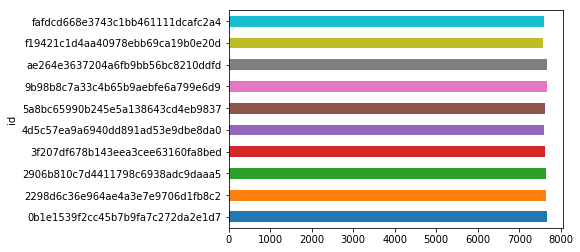

In [116]:
# how many of each offer were received?
transcript[transcript['event'] == 'offer received'].groupby(['id'])['event'].count().plot.barh()

Approximately the same number of offers was sent out for each of the ten types of offers.

In [117]:
# check if the values in the 'offer_id' column of transcript are the same as the values in the 'id' column of portfolio.
# first, remove the nan (if any) from the set of values in the 'offer_id' column in transcript. there probably will be nan
# in the set from the 'reward' and 'amount' keys in the 'value' column.

# create a set of the values in the 'offer_id' column in transcript
s = set(transcript['id'].unique())
# remove nan exploiting that in python nan != nan
{e for e in s if e  == e}

assert {e for e in s if e  == e} == set(portfolio['id'].unique()), 'They are DIFFERENT'
print('They are the SAME.')

They are the SAME.


In [118]:
# the value column is not needed any more, as its information is contained in the offer_id, amount and reward columns
transcript.drop(columns=['value'], inplace=True)

In [119]:
# check offer received times for each of the offers
for id in transcript['id'].unique():
    print('id: {} received timing: {}'.format(id, transcript[(transcript['id'] == id) & (transcript['event'] == 'offer received')]['time'].unique()))

id: 9b98b8c7a33c4b65b9aebfe6a799e6d9 received timing: [  0 168 336 408 504 576]
id: 0b1e1539f2cc45b7b9fa7c272da2e1d7 received timing: [  0 168 336 408 504 576]
id: 2906b810c7d4411798c6938adc9daaa5 received timing: [  0 168 336 408 504 576]
id: fafdcd668e3743c1bb461111dcafc2a4 received timing: [  0 168 336 408 504 576]
id: 4d5c57ea9a6940dd891ad53e9dbe8da0 received timing: [  0 168 336 408 504 576]
id: f19421c1d4aa40978ebb69ca19b0e20d received timing: [  0 168 336 408 504 576]
id: 2298d6c36e964ae4a3e7e9706d1fb8c2 received timing: [  0 168 336 408 504 576]
id: 3f207df678b143eea3cee63160fa8bed received timing: [  0 168 336 408 504 576]
id: ae264e3637204a6fb9bb56bc8210ddfd received timing: [  0 168 336 408 504 576]
id: 5a8bc65990b245e5a138643cd4eb9837 received timing: [  0 168 336 408 504 576]
id: nan received timing: []


The different types of offers were all received at the same times (not necessary that each person received each offer every time the offers were sent out). The nan id in the transcript data frame corresponds to transactions.

In [120]:
# calculate expiration times for each of the offers. duration in the portfolio data frame is in days.
for id in transcript['id'].unique():
    print('offer: {} expiration timing: {}'.format(id, transcript[(transcript['id'] == id) & 
                                                                  (transcript['event'] == 'offer received')]['time'].unique() + 
                                                   portfolio[portfolio['id'] == id]['duration'].values * 24))

offer: 9b98b8c7a33c4b65b9aebfe6a799e6d9 expiration timing: [168 336 504 576 672 744]
offer: 0b1e1539f2cc45b7b9fa7c272da2e1d7 expiration timing: [240 408 576 648 744 816]
offer: 2906b810c7d4411798c6938adc9daaa5 expiration timing: [168 336 504 576 672 744]
offer: fafdcd668e3743c1bb461111dcafc2a4 expiration timing: [240 408 576 648 744 816]
offer: 4d5c57ea9a6940dd891ad53e9dbe8da0 expiration timing: [120 288 456 528 624 696]
offer: f19421c1d4aa40978ebb69ca19b0e20d expiration timing: [120 288 456 528 624 696]
offer: 2298d6c36e964ae4a3e7e9706d1fb8c2 expiration timing: [168 336 504 576 672 744]
offer: 3f207df678b143eea3cee63160fa8bed expiration timing: [ 96 264 432 504 600 672]
offer: ae264e3637204a6fb9bb56bc8210ddfd expiration timing: [168 336 504 576 672 744]
offer: 5a8bc65990b245e5a138643cd4eb9837 expiration timing: [ 72 240 408 480 576 648]
offer: nan expiration timing: []


The last expiration time for any offer was t=816. Since the last time stamp in the event log is t=714, it means that some offers were still open when the test event logging ended.

Completed offers that were viewed before completion can be categorized as successful offers.

Offers that expired before or at end of the test (t=714) without being completed can be categorized as unsuccessful offers.

Offers that were not completed but had not yet expired at the end of the test must be categorized as inconclusive.

### Since some offers had not expired at the end of the event log, detailed accounting is needed to categorize each offer to each person as successful, unsuccessful or inconclusive.

This is done by the following:

# CATEGORIZE THE OUTCOME OF EACH OFFER MADE TO EACH PERSON

The next step is to categorize the outcome of each offer received by each person. The categories are as follows:
1. Successful: person received, viewed and completed the offer before it expired;
2. Unsuccessful: person received and viewed the offer. The expiry was within the test period, but the person did not complete the offer before it expired;
3. Inconclusive: person received and viewed the offer. The expiry was after the end of the test period. The person did not complete the offer before the test period ended, but had time to complete it after the test period ended;
4. Unsolicited: a transaction made without viewing an offer;
5. Lost: person received the offer but did not view it or make a purchase.

In [121]:
end_of_time = 9999
# this is used as the time stamp for an event that is not in the transcript file. 
# for example, the viewing time for an offer that was never viewed will be set to this value.

In [122]:
# time at which transcript ends
t_end = transcript['time'].max()

In [123]:
if read_saved_categorization:
    df_all_person_offer = pd.read_pickle(reorganized_transcript_file)
else:
    df_all_person_offer = pd.DataFrame()

    for person in tqdm(transcript['person'].unique()):
        temp = pd.DataFrame()
        t = transcript_for_person(person)
    
        r = t[t['event'] == 'offer received'].copy()
        r.rename(columns={'time':'received'}, inplace=True)
        r.drop(columns='reward', inplace=True)
        r = r.merge(portfolio, on='id', how='left')
        r['expires'] = r['received'] + 24 * r['duration']
        r.drop(columns=['channels','offer_type','event'], inplace=True)
        r['amount'] = 0
    
        v = t[t['event'] == 'offer viewed'].drop(columns=['event','amount','reward']).rename(columns={'time':'viewed'}).copy()
    
        rv = pd.merge_asof(r, v, left_on='received', right_on='viewed', by=['person','id'], direction='forward')
        rv['difficulty'] = rv['difficulty'].astype(float)
        rv.loc[rv[rv['id'].isin(info_offers_lst)].index, 'difficulty'] = 0.01
        rv.loc[rv[rv['viewed'].isna()].index, 'viewed'] = end_of_time
        rv['completed'] = end_of_time
    
        tr = t[t['event'] == 'transaction']
    
        for idx_tr in tr.index:
            tr_time, credit = tr.loc[idx_tr, ['time','amount']]
            credit0 = credit
            #print(idx_tr, tr_time, credit)
            for idx_rv in rv.index:
                #print(tr_time, rv.loc[idx_rv,'viewed'], rv.loc[idx_rv,'expires'], credit)
                if (tr_time >= rv.loc[idx_rv,'viewed']) & (tr_time <= rv.loc[idx_rv,'expires']):
                    if credit >= rv.loc[idx_rv,'difficulty']-rv.loc[idx_rv,'amount']:
                        rv.loc[idx_rv,'completed'] = tr_time
                    allocate = np.min([rv.loc[idx_rv,'difficulty']-rv.loc[idx_rv,'amount'], credit])
                    rv.loc[idx_rv,'amount'] += allocate
                    credit -= allocate
                #display(rv)
            if credit == credit0:
#            print('transaction at {} was unsolicited'.format(tr_time))
#            rv = rv.append(pd.DataFrame(data={'person':[person],'id':['unsolicited transaction'],'received':[0],'expires':[t_end],'viewed':[end_of_time],'completed':[tr_time],'amount':[credit],'difficulty':[0],'duration':[0],'reward':[0]}))
                temp = temp.append(pd.DataFrame(data={'person':[person],'id':['unsolicited transaction'],'received':[0],'expires':[t_end],'viewed':[end_of_time],'completed':[tr_time],'amount':[credit],'difficulty':[0],'duration':[0],'reward':[0]}),sort=False)
        rv = rv.append(temp,sort=False)
        
        df_all_person_offer = df_all_person_offer.append(rv,sort=False)
        
    df_all_person_offer.to_pickle(reorganized_transcript_file)

In [124]:
# mark whether or not each offer is successful
df_all_person_offer['successful'] = (
    (df_all_person_offer['viewed'] < end_of_time) & 
    (df_all_person_offer['viewed'] >= df_all_person_offer['received']) &
    (df_all_person_offer['viewed'] <= df_all_person_offer['expires']) &
    (df_all_person_offer['completed'] < end_of_time) &
    (df_all_person_offer['completed'] >= df_all_person_offer['viewed']) &
    (df_all_person_offer['completed'] <= df_all_person_offer['expires'])
).astype(int)


In [125]:
# mark whether or not each offer is unsuccessful
df_all_person_offer['unsuccessful'] = (
    (df_all_person_offer['viewed'] < end_of_time) &
    (df_all_person_offer['viewed'] >= df_all_person_offer['received']) &
    (df_all_person_offer['viewed'] <= df_all_person_offer['expires']) &
    (df_all_person_offer['completed'] == end_of_time) &
    (df_all_person_offer['expires'] <= t_end)
).astype(int)

In [126]:
# mark whether or not each offer is inconclusive
df_all_person_offer['inconclusive'] = (
    (df_all_person_offer['viewed'] < end_of_time) &
    (df_all_person_offer['viewed'] >= df_all_person_offer['received']) &
    (df_all_person_offer['viewed'] <= df_all_person_offer['expires']) &
    (df_all_person_offer['completed'] == end_of_time) &
    (df_all_person_offer['expires'] > t_end)
).astype(int)

In [127]:
# mark whether or not each offer is unsolicited
df_all_person_offer['unsolicited'] = (
    ((df_all_person_offer['viewed'] < end_of_time) &
     (df_all_person_offer['viewed'] >= df_all_person_offer['received']) &
     (df_all_person_offer['viewed'] <= df_all_person_offer['expires']) &
     (df_all_person_offer['completed'] < end_of_time) &
     (df_all_person_offer['completed'] > df_all_person_offer['expires'])) |
    
    ((df_all_person_offer['viewed'] < end_of_time) &
     (df_all_person_offer['viewed'] >= df_all_person_offer['received']) &
     (df_all_person_offer['viewed'] <= df_all_person_offer['expires']) &
     (df_all_person_offer['completed'] < end_of_time) &
     (df_all_person_offer['completed'] < df_all_person_offer['viewed'])) |    
    
    ((df_all_person_offer['viewed'] < end_of_time) &
     (df_all_person_offer['viewed'] >= df_all_person_offer['received']) &
     (df_all_person_offer['viewed'] > df_all_person_offer['expires']) &
     (df_all_person_offer['completed'] < end_of_time)) |
    
    ((df_all_person_offer['viewed'] == end_of_time) &
     (df_all_person_offer['completed'] < end_of_time))
).astype(int)

In [128]:
# mark whether or not each offer is lost
df_all_person_offer['lost'] = (((df_all_person_offer['viewed'] == end_of_time) &
             (df_all_person_offer['completed'] == end_of_time)) |
             ((df_all_person_offer['viewed'] < end_of_time) &
              (df_all_person_offer['viewed'] >= df_all_person_offer['received']) &
             (df_all_person_offer['viewed'] > df_all_person_offer['expires']) &
             (df_all_person_offer['completed'] == end_of_time)) 
            ).astype(int)

Run some QC. Each offer to each person can only have one outcome, i.e., the sum of the 'successful', 'unsuccessful', 'inconclusive','unsolicited' and 'lost' columns must equal 1.

In [129]:
# QC the results: check that one and only one of the following columns contains 1
stats = (df_all_person_offer['successful'] + df_all_person_offer['unsuccessful'] + df_all_person_offer['inconclusive'] + df_all_person_offer['unsolicited'] + df_all_person_offer['lost']).describe()
assert stats['min'] == 1, 'some offers are undercategorized'
assert stats['max'] == 1, 'some offers are overcategorized'
print('categorization appears ok')

categorization appears ok


In [130]:
df_all_person_offer['total'] = df_all_person_offer['successful'] + df_all_person_offer['unsuccessful'] + \
df_all_person_offer['inconclusive'] + df_all_person_offer['unsolicited'] + df_all_person_offer['lost']

In [131]:
# another way to check the same thing is to cunt how many rows in the 'total' column are not equal to 1
assert df_all_person_offer[df_all_person_offer['total'] != 1]['id'].count() == 0, 'the total for some rows is not 1'
print('sum for each row equals 1')

sum for each row equals 1


The above QC is satisfied.

Another QC check is whether the total number of offers received equals the total number of outcomes:

In [132]:
outcomes = ['successful', 'unsuccessful', 'inconclusive', 'unsolicited', 'lost']

In [133]:
# QC the results: the number of offers received must equal the sum of the number of offers in each of the 'successful',
# 'unsuccessful', 'inconclusive', 'unsolicited' and 'lost' categories
for offer in portfolio['id'].unique():
    n_received = transcript[(transcript['id'] == offer) & (transcript['event'] == 'offer received') & (transcript['person'].isin(df_all_person_offer['person'].unique()))]['id'].count()
    n_successful = df_all_person_offer[(df_all_person_offer['id'] == offer) & (df_all_person_offer['successful'] == 1)]['id'].count()
    n_unsuccessful = df_all_person_offer[(df_all_person_offer['id'] == offer) & (df_all_person_offer['unsuccessful'] == 1)]['id'].count()
    n_inconclusive = df_all_person_offer[(df_all_person_offer['id'] == offer) & (df_all_person_offer['inconclusive'] == 1)]['id'].count()
    n_unsolicited = df_all_person_offer[(df_all_person_offer['id'] == offer) & (df_all_person_offer['unsolicited'] == 1)]['id'].count()
    n_lost = df_all_person_offer[(df_all_person_offer['id'] == offer) & (df_all_person_offer['lost'] == 1)]['id'].count()
    n_outcomes = n_successful + n_unsuccessful + n_inconclusive + n_unsolicited + n_lost
    assert n_received == n_outcomes, 'offer: {} ERROR n_received != n_outcomes'.format(offer)
    print('offer: {} n_received == n_outcomes is OK'.format(offer))

offer: ae264e3637204a6fb9bb56bc8210ddfd n_received == n_outcomes is OK
offer: 4d5c57ea9a6940dd891ad53e9dbe8da0 n_received == n_outcomes is OK
offer: 3f207df678b143eea3cee63160fa8bed n_received == n_outcomes is OK
offer: 9b98b8c7a33c4b65b9aebfe6a799e6d9 n_received == n_outcomes is OK
offer: 0b1e1539f2cc45b7b9fa7c272da2e1d7 n_received == n_outcomes is OK
offer: 2298d6c36e964ae4a3e7e9706d1fb8c2 n_received == n_outcomes is OK
offer: fafdcd668e3743c1bb461111dcafc2a4 n_received == n_outcomes is OK
offer: 5a8bc65990b245e5a138643cd4eb9837 n_received == n_outcomes is OK
offer: f19421c1d4aa40978ebb69ca19b0e20d n_received == n_outcomes is OK
offer: 2906b810c7d4411798c6938adc9daaa5 n_received == n_outcomes is OK


Passed the QC.

In [134]:
# merge the df_all_person_offer data frame and profile data frame
df_all_person_offer = df_all_person_offer.merge(profile, how='left', left_on='person', right_on='id')

In [135]:
df_all_person_offer.columns

Index(['person', 'received', 'id_x', 'amount', 'difficulty', 'duration',
       'reward', 'bogo', 'discount', 'informational', 'email', 'mobile',
       'social', 'web', 'type_diff_dur_rew', 'expires', 'viewed', 'completed',
       'successful', 'unsuccessful', 'inconclusive', 'unsolicited', 'lost',
       'total', 'age', 'became_member_on', 'gender', 'id_y', 'income',
       'became_member_day', 'became_member_month', 'became_member_year',
       'cluster'],
      dtype='object')

In [136]:
# cleanup columns
# drop column 'id_y'
df_all_person_offer.drop(columns='id_y', inplace=True)

In [137]:
# cleanup columns
# rename column'id_x' to 'offer'
df_all_person_offer.rename(columns={'id_x': 'offer'}, inplace=True)

In [138]:
# add categorical columns for gender
df_all_person_offer['M'] = df_all_person_offer['gender'].apply(lambda x: 1 if x == 'M' else 0)
df_all_person_offer['F'] = df_all_person_offer['gender'].apply(lambda x: 1 if x == 'F' else 0)
df_all_person_offer['O'] = df_all_person_offer['gender'].apply(lambda x: 1 if x == 'O' else 0)

### Define functions to use for plotting the results

In [139]:
def display_outcomes_by_group(df, groups):
    '''
    groups the dataframe by the specified groups and calculates and displays the percent in each group
    Inputs:
        df: data frame for which statistics have to calculated and displayed per the specified groups
        groups: specified groups
    Outputs: data frame containing calculated statistics according to the specified grouping
    '''
    df_calc = df.groupby(groups)[outcomes].sum()
    df_calc['total'] = df_calc['successful'] + df_calc['unsuccessful'] + df_calc['inconclusive'] + \
        df_calc['unsolicited'] + df_calc['lost']
    df_calc['successful%'] = df_calc['successful'] / df_calc['total'] * 100
    df_calc['unsolicited%'] = df_calc['unsolicited'] / df_calc['total'] * 100
    df_calc['unsuccessful%'] = df_calc['unsuccessful'] / df_calc['total'] * 100
    df_calc['inconclusive%'] = df_calc['inconclusive'] / df_calc['total'] * 100
    df_calc['lost%'] = df_calc['lost'] / df_calc['total'] * 100

    return df_calc[pd.DataFrame(columns=outcomes).add_suffix('%').columns.tolist()]

### Display outcome for each offer

In [337]:
# convert the numbers to percentages
df_outcome = display_outcomes_by_group(df_all_person_offer, ['offer'])

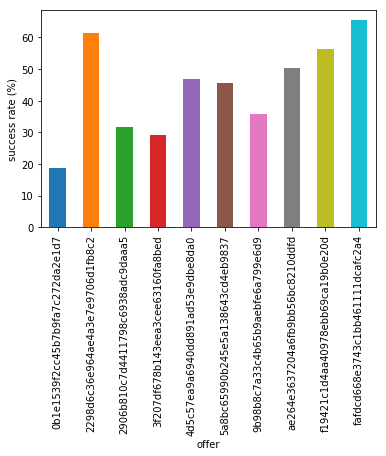

In [353]:
# make a chart of the percentage successful outcomes for each offer.
temp = df_outcome.drop(index='unsolicited transaction').unstack(level='offer')['successful%'].transpose()
ax = temp.plot(kind='bar')
ax.set_xlabel('offer')
ax.set_ylabel('success rate (%)');

In [351]:
temp

offer
0b1e1539f2cc45b7b9fa7c272da2e1d7    18.818466
2298d6c36e964ae4a3e7e9706d1fb8c2    61.509286
2906b810c7d4411798c6938adc9daaa5    31.800314
3f207df678b143eea3cee63160fa8bed    29.302875
4d5c57ea9a6940dd891ad53e9dbe8da0    47.043329
5a8bc65990b245e5a138643cd4eb9837    45.471252
9b98b8c7a33c4b65b9aebfe6a799e6d9    35.808258
ae264e3637204a6fb9bb56bc8210ddfd    50.261165
f19421c1d4aa40978ebb69ca19b0e20d    56.425835
fafdcd668e3743c1bb461111dcafc2a4    65.420561
dtype: float64

### Display outcomes for each offer broken down by gender

In [140]:
# what do the outcomes look like, broken down by gender?
df_all_person_offer.groupby(['gender'])[outcomes].sum()

,successful,unsuccessful,inconclusive,unsolicited,lost
gender,,,,,
F,14345,5255,804,30544,7052
M,17062,9417,1471,40155,10179
O,525,218,29,1092,144


In [141]:
# convert the numbers to percentages
df_outcome_gender = display_outcomes_by_group(df_all_person_offer, ['offer', 'gender'])

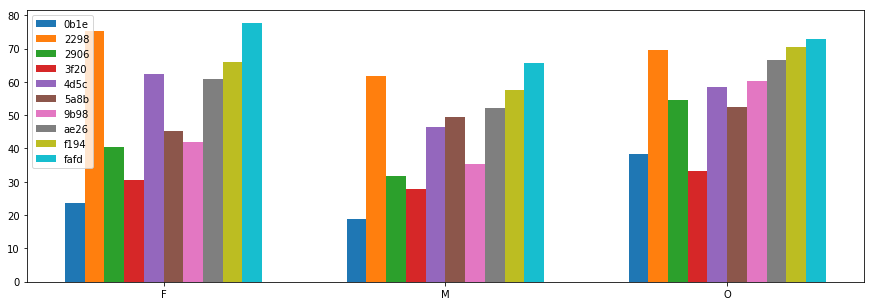

In [142]:
# make a chart of the percentage successful outcomes for each offer.
temp = df_outcome_gender.drop(index='unsolicited transaction').unstack(level='offer')['successful%'].transpose()
make_clustered_bar_chart(temp.values, temp.columns, [s[0:4] for s in temp.index], len(temp.index))

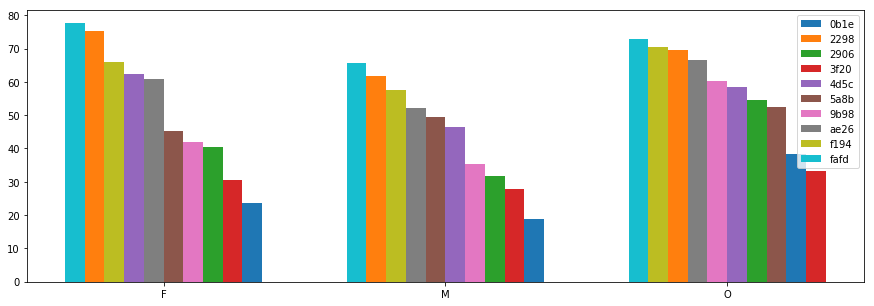

In [143]:
# make a chart of the percentage successful outcomes for each offer, sorted from most to least successful within each gender
temp = df_outcome_gender.drop(index='unsolicited transaction').unstack(level='offer')['successful%'].transpose()
make_sorted_clustered_bar_chart(temp.values, temp.columns, [s[0:4] for s in temp.index], len(temp.index))

The above chart shows that **fafd**, **2298** and **f194** were the most successful offers for each of the three genders. **0b1e** was the least successful.

Of the successful offers:
1. **fafd** was a **20% discount** offer with difficulty of **10**.
2. **2298** was a **43% discount** offer with difficulty of **7**.
3. **f194** was a **bogo** offer with difficulty of **5**.

On the other hand, the least successful offer, **0b1e** was a **20% discount** offer with a difficulty of **20**.

**It appears (from this one chart) as if offers with a lower difficulty level are more successful.**

**2906**, another 20% discount offer was less successful that the other similar % and dificulty discount offers, perhaps because of its lower duration.

The other bogo offer with a low difficulty, **9b98**, was not as successful with M and F gender, for reasons not clear from the above chart. Bogo offers with higher difficulty, **ae26** and **4d5c** showed average success rates.

Success rates appear to be slightly higher with the F gender relative to M gender, perhaps because of the F gender's higher average income.

Offers seem to be more successful with the O gender than with F and M genders.

### Display outcomes for each offer broken down by became_member_year

In [144]:
# what do the outcomes look like, broken down by became_member_year?
df_all_person_offer.groupby(['became_member_year'])[outcomes].sum()

,successful,unsuccessful,inconclusive,unsolicited,lost
became_member_year,,,,,
2013,694,216,38,1786,338
2014,1686,540,102,4192,779
2015,4620,1292,204,11208,2093
2016,9266,2272,354,20962,3867
2017,12414,7953,1242,27865,7390
2018,5001,7759,1242,10770,4915


The trend of enrolment increasing every year appears to be broken in 2018. Perhaps the profile data set does not cover all of 2018. Let's check the months in which enrolment occurred.

In [145]:
np.sort(profile[profile['became_member_year'] == 2018]['became_member_month'].unique())

array([1, 2, 3, 4, 5, 6, 7])

Yup, the profile data set only contains enrolment through July 2018. The test was conducted in August 2018, perhaps.

In [146]:
# convert the numbers to percentages
df_outcome_year = display_outcomes_by_group(df_all_person_offer, ['offer', 'became_member_year'])

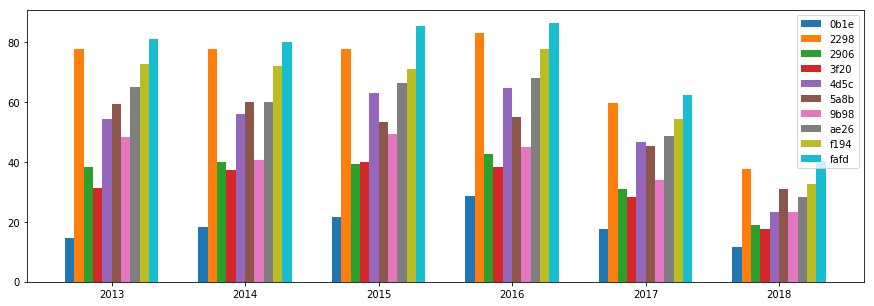

In [147]:
# make a chart of the percentage successful outcomes for each offer.
temp = df_outcome_year.drop(index='unsolicited transaction').unstack(level='offer')['successful%'].transpose()
make_clustered_bar_chart(temp.values, temp.columns, [s[0:4] for s in temp.index], len(temp.index))

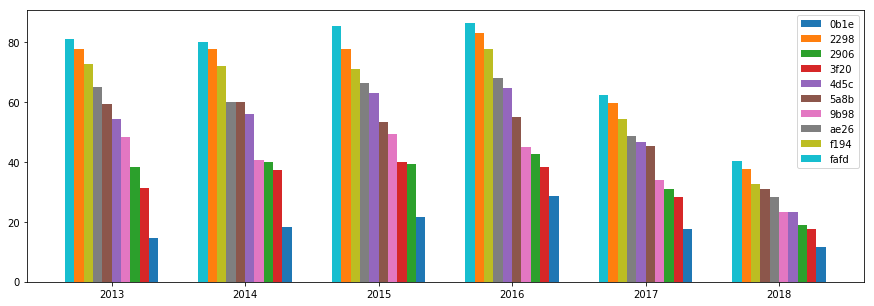

In [148]:
# make a chart of the percentage successful outcomes for each offer. sorted from most to least successful within each
# year
temp = df_outcome_year.drop(index='unsolicited transaction').unstack(level='offer')['successful%'].transpose()
make_sorted_clustered_bar_chart(temp.values, temp.columns, [s[0:4] for s in temp.index], len(temp.index))

The low-difficulty discount offers **fafd** and **2298** offers were the most successful, regardless of how long the customer was a member. The informational offer **5a8b** and low-difficulty bogo offer **f194** were also successful. The high-difficulty discount offer **0b1e** was the least successful.

The higher-difficulty bogo offers **4d5c** and **ae26** had better success with customers who became members in 205 and 2016.

Overall, success rates increased the longer a customer had been a member for the most successful offers.

### Display outcomes for each offer broken down by income bracket

In [149]:
# check the income statistics - use it to define income brackets
profile['income'].describe()

count     14825.000000
mean      65404.991568
std       21598.299410
min       30000.000000
25%       49000.000000
50%       64000.000000
75%       80000.000000
max      120000.000000
Name: income, dtype: float64

In [150]:
# add column to df_all_person_offer for the income brackets
income_brackets = [(30000,49999), (50000,69999), (70000,89999), (90000,109999),(110000,120000)]

def pick_income_bracket(income):
    '''
    selects the number of the income bracket based on income brackets and income
    Input: income
    Output: bracket number
    '''
    if np.isnan(income):
        bracket_num = np.nan
    else:
        for i, bracket in enumerate(income_brackets):
            low = income_brackets[i][0]
            high = income_brackets[i][1]
            if (income >= low) & (income <= high):
                bracket_num = str(i)
                break
            
    return bracket_num
            

for i, bracket in income_brackets:
    df_all_person_offer['income bracket'] = df_all_person_offer['income'].apply(lambda x: pick_income_bracket(x))

In [151]:
# what do the outcomes look like, broken down by income bracket?
df_all_person_offer.groupby(['income bracket'])[outcomes].sum()

,successful,unsuccessful,inconclusive,unsolicited,lost
income bracket,,,,,
0,6650,4102,689,20489,5526
1,11183,5370,847,25787,5028
2,8802,3502,516,16272,3963
3,4179,1564,216,7135,2002
4,1118,352,36,2108,856


In [152]:
# convert the numbers to percentages
df_outcome_income = display_outcomes_by_group(df_all_person_offer, ['offer', 'income bracket'])

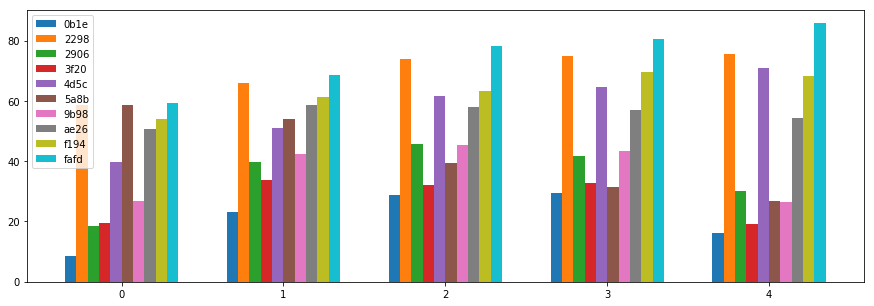

In [153]:
# make a chart of the percentage successful outcomes for each offer.
temp = df_outcome_income.drop(index='unsolicited transaction').unstack(level='offer')['successful%'].transpose()
make_clustered_bar_chart(temp.values, temp.columns, [s[0:4] for s in temp.index], len(temp.index))

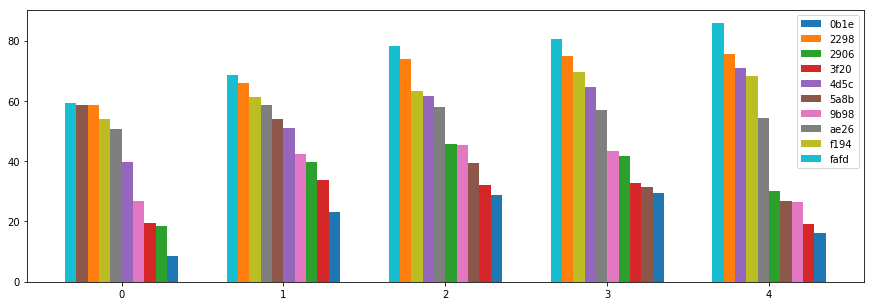

In [154]:
# make a chart of the percentage successful outcomes for each offer. sorted from most to least successful 
# within each income bracket
temp = df_outcome_income.drop(index='unsolicited transaction').unstack(level='offer')['successful%'].transpose()
make_sorted_clustered_bar_chart(temp.values, temp.columns, [s[0:4] for s in temp.index], len(temp.index))

Once again, the low-difficulty discount offers **fafd** and **2298** were the most successful across income brackets. The informational offer **5a8b** had higher success in the lower income bracket, while the bogo offer **f194** had higher success in the higher income brackets. 

Interestingly, some offers had better success with the middle income brackets:
1. High-difficulty discount offer **0b1e** (but still, lowest success overall);
2. Informational offer **3f20**;
3. Low-duration, 20% discount offer **2906**;
4. Low-difficulty bogo offer **9b98**.

### Display outcomes for each offer broken down by age bracket

In [155]:
# check the age statistics - use it to define age brackets
profile['age'].describe()

count    14825.000000
mean        54.393524
std         17.383705
min         18.000000
25%         42.000000
50%         55.000000
75%         66.000000
max        101.000000
Name: age, dtype: float64

In [156]:
# add column to df_all_person_offer for the age brackets
age_brackets = [(18,24), (25,34), (35,44), (45,54), (55,64), (65,74), (75,84), (85,104)]

def pick_age_bracket(age):
    '''
    selects the number of the age bracket based on age brackets and age
    Input: age
    Output: bracket number
    '''
    if np.isnan(age):
        bracket_num = np.nan
    else:
        for i, bracket in enumerate(age_brackets):
            if (age >= age_brackets[i][0]) & (age <= age_brackets[i][1]):
                bracket_num = str(i)
                break
            
    return bracket_num
            

for i, bracket in age_brackets:
    df_all_person_offer['age bracket'] = df_all_person_offer['age'].apply(lambda x: pick_age_bracket(x))

In [157]:
# what do the outcomes look like, broken down by age bracket?
df_all_person_offer.groupby(['age bracket'])[outcomes].sum()

,successful,unsuccessful,inconclusive,unsolicited,lost
age bracket,,,,,
0,1586,972,134,4879,1246
1,2643,1351,263,8056,1971
2,4208,1912,319,9869,1942
3,6578,3105,480,13864,3255
4,7518,3440,519,15508,3986
5,5326,2432,351,11211,2885
6,2795,1139,162,5750,1369
7,1278,539,76,2654,721


In [158]:
# convert the numbers to percentages
df_outcome_age = display_outcomes_by_group(df_all_person_offer, ['offer', 'age bracket'])

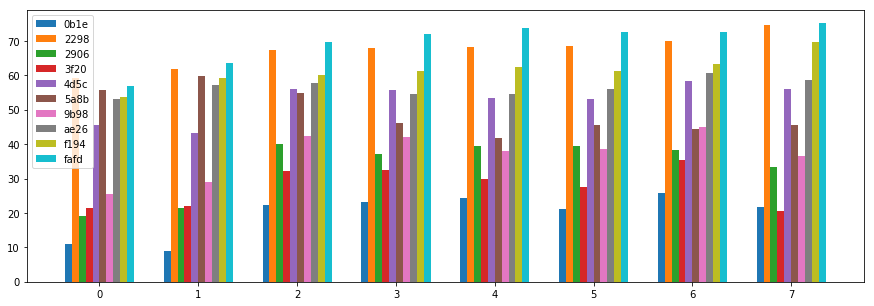

In [159]:
# make a chart of the percentage successful outcomes for each offer.
temp = df_outcome_age.drop(index='unsolicited transaction').unstack(level='offer')['successful%'].transpose()
make_clustered_bar_chart(temp.values, temp.columns, [s[0:4] for s in temp.index], len(temp.index))

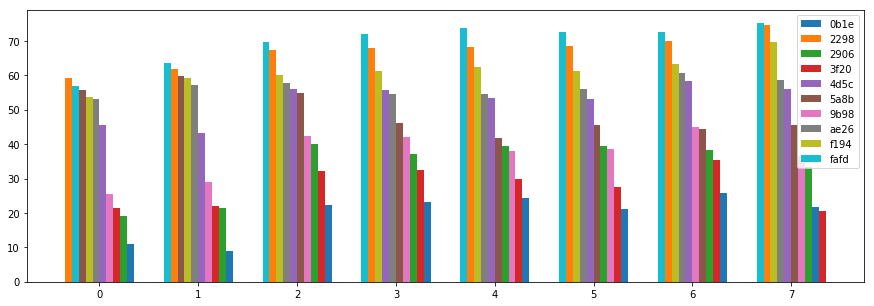

In [160]:
# make a chart of the percentage successful outcomes for each offer. sorted from most to least 
# successful within each age bracket
temp = df_outcome_age.drop(index='unsolicited transaction').unstack(level='offer')['successful%'].transpose()
make_sorted_clustered_bar_chart(temp.values, temp.columns, [s[0:4] for s in temp.index], len(temp.index))

As with breakdowns on other bases, the low-difficulty discount offers **fafd** and **2298** had the most success across all age brackets. The information offer **5a8b** had good success with the lower age bracket which tapered off with age. This could be due to the positive correlation between age and income. The low-difficulty bogo offer **f194** had higher success in the higher age bracket, perhaps due to the age-income correlation.

As with income,, some offers had better success with the middle age brackets:
1. Informational offer **3f20**;
2. Low-duration, 20% discount offer **2906**.

The high-difficulty discount offer **0b1e** did better with higher age brackets (but still, lowest success overall) as did the low-difficulty bogo offer **9b98**. This is counter to the positive correlation between age and income. Perhaps a factor other than income drives this behavior for these offers.

### Display outcomes for each offer broken down by gender and income bracket

In [161]:
# convert the numbers to percentages
df_outcome_gender_income = display_outcomes_by_group(df_all_person_offer, ['offer','gender','income bracket'])

In [162]:
df_outcome_gender_income.reset_index(inplace=True)

In [163]:
# what do the outcome percentages look like?
df_outcome_gender_income.head()

,offer,gender,income bracket,successful%,unsuccessful%,inconclusive%,unsolicited%,lost%
0,0b1e1539f2cc45b7b9fa7c272da2e1d7,F,0,11.673152,4.474708,3.696498,0.0,80.155642
1,0b1e1539f2cc45b7b9fa7c272da2e1d7,F,1,29.331683,8.787129,5.940594,0.0,55.940594
2,0b1e1539f2cc45b7b9fa7c272da2e1d7,F,2,26.333712,7.377980,6.015891,0.0,60.272418
3,0b1e1539f2cc45b7b9fa7c272da2e1d7,F,3,25.223214,5.803571,6.026786,0.0,62.946429
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,F,4,16.000000,2.000000,2.000000,0.0,80.000000


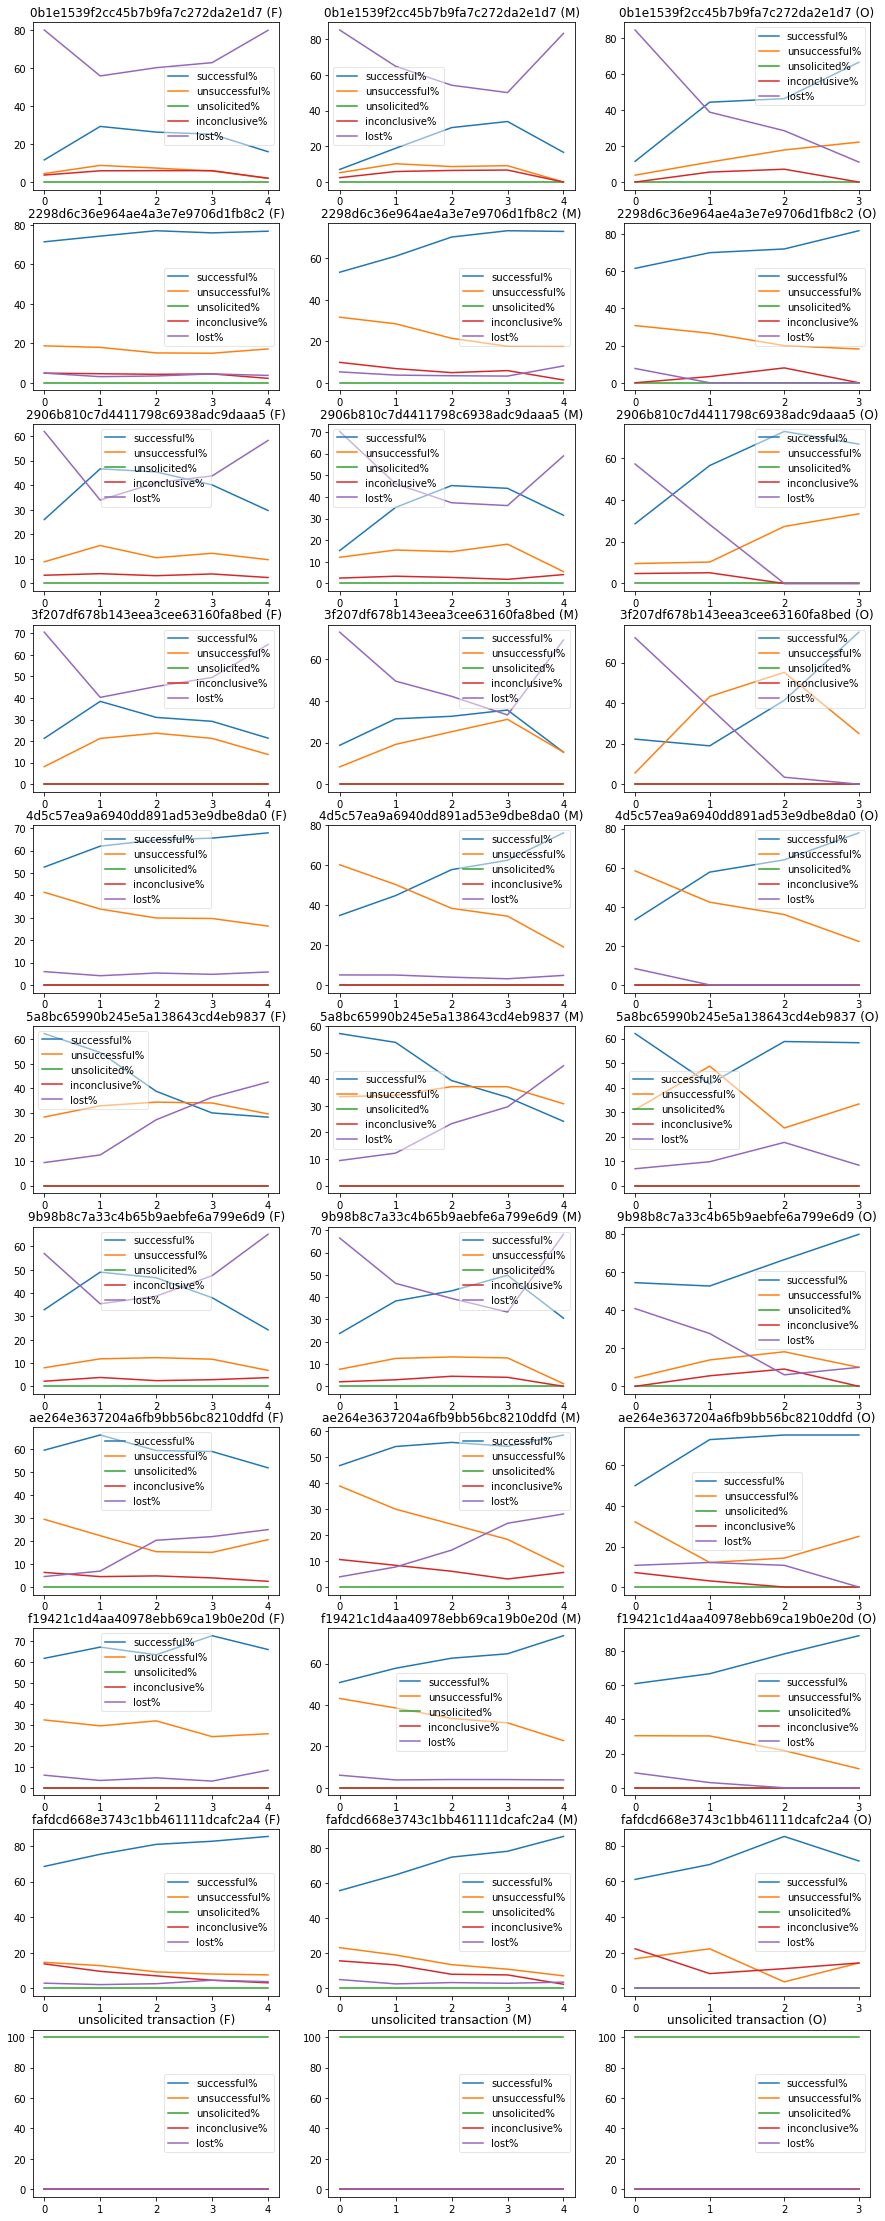

In [164]:
n_gender = df_outcome_gender_income['gender'].nunique()
n_offer = df_outcome_gender_income['offer'].nunique()
i_plot = 0
plt.figure(figsize=(15,40))
for offer in df_outcome_gender_income['offer'].unique():
    for gender in df_outcome_gender_income['gender'].unique():
        i_plot += 1
        plt.subplot(n_offer, n_gender, i_plot)
        df = df_outcome_gender_income[(df_outcome_gender_income['offer'] == offer) & (df_outcome_gender_income['gender'] == gender)]
        plt.plot(df['income bracket'], df['successful%'])
        plt.plot(df['income bracket'], df['unsuccessful%'])
        plt.plot(df['income bracket'], df['unsolicited%'])
        plt.plot(df['income bracket'], df['inconclusive%'])
        plt.plot(df['income bracket'], df['lost%'])
        plt.title(offer + ' (' + gender + ')')
        plt.legend(framealpha=0.5)

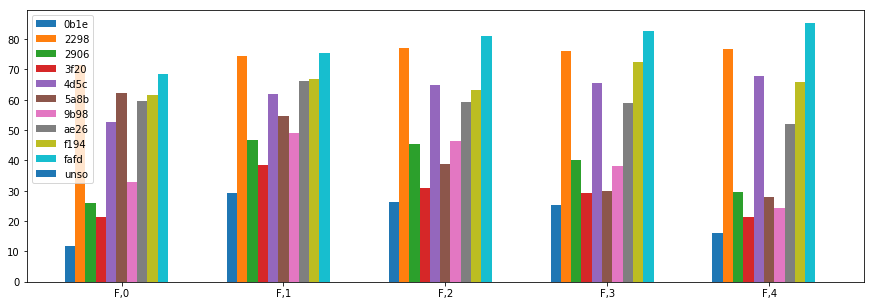

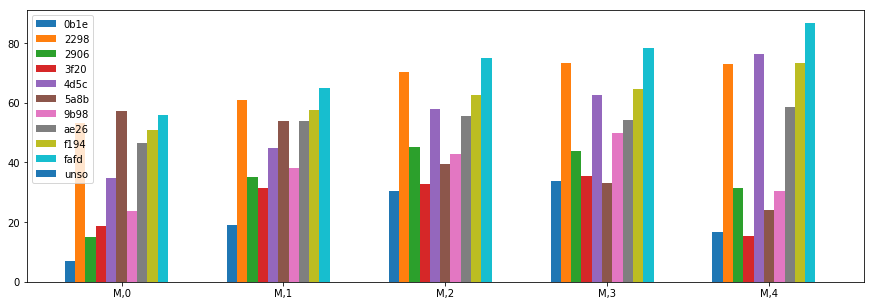

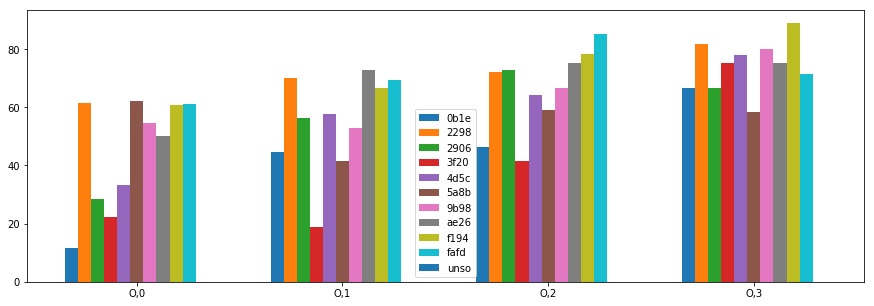

In [165]:
# make a chart of the percentage successful outcomes for each offer.
for gender in df_outcome_gender_income['gender'].unique():
    temp = df_outcome_gender_income[df_outcome_gender_income['gender'] == gender][['offer','income bracket','successful%']].pivot(index='offer', columns='income bracket')
    make_clustered_bar_chart(temp.values, [gender + ',' + s for s in temp.columns.levels[1]],
                             [s[0:4] for s in temp.index], temp.shape[0])

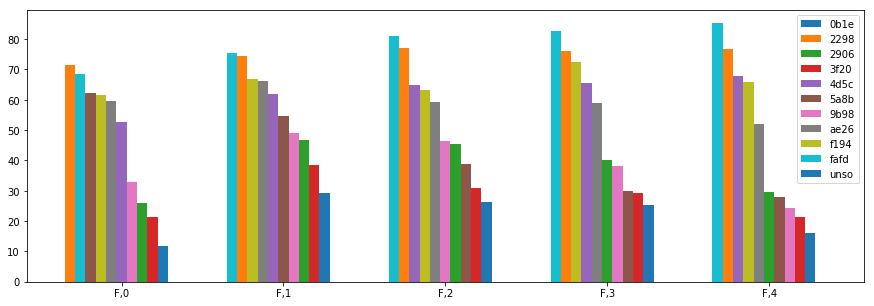

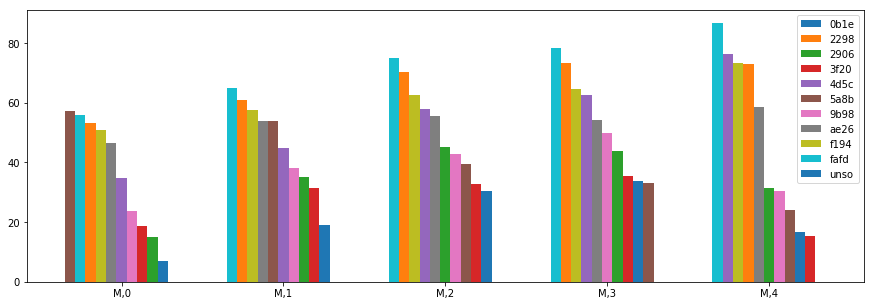

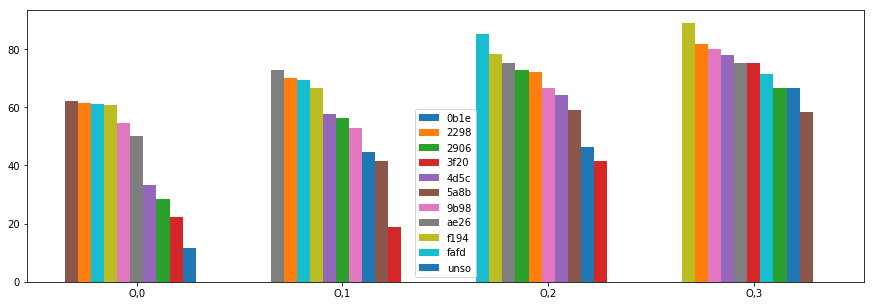

In [166]:
# make a chart of the percentage successful outcomes for each offer. sorted from most to least successful
# withing each income bracket
for gender in df_outcome_gender_income['gender'].unique():
    temp = df_outcome_gender_income[df_outcome_gender_income['gender'] == gender][['offer','income bracket','successful%']].pivot(index='offer', columns='income bracket')
    make_sorted_clustered_bar_chart(temp.values, [gender + ',' + s for s in temp.columns.levels[1]],
                             [s[0:4] for s in temp.index], temp.shape[0])

In [167]:
# check the number of customers in the income brackets for the O gender
df_all_person_offer[df_all_person_offer['gender'] == 'O'].groupby('income bracket')['person'].count()

income bracket
0    521
1    777
2    537
3    173
Name: person, dtype: int64

The behavior for F and M genders versus income is as would be expected from preceeding charts of income only. 

The chart for O gender shows quite different behavior. Bear in mind that the O gender group is much smaller than the F and M gender groups. Also the highest income bracket is missing in the O gender group. Generally, all offers (even **0b1e**) did much better in the higher income brackets than with other demographic groups.

### Display outcomes for each offer broken down by gender and age bracket

In [168]:
# convert the numbers to percentages
df_outcome_gender_age = display_outcomes_by_group(df_all_person_offer, ['offer','gender','age bracket'])

In [169]:
df_outcome_gender_age.reset_index(inplace=True)

In [170]:
# what do the outcome percentages look like?
df_outcome_gender_age.head()

,offer,gender,age bracket,successful%,unsuccessful%,inconclusive%,unsolicited%,lost%
0,0b1e1539f2cc45b7b9fa7c272da2e1d7,F,0,14.545455,3.636364,0.909091,0.0,80.909091
1,0b1e1539f2cc45b7b9fa7c272da2e1d7,F,1,11.602210,4.972376,2.762431,0.0,80.662983
2,0b1e1539f2cc45b7b9fa7c272da2e1d7,F,2,27.106227,8.058608,5.860806,0.0,58.974359
3,0b1e1539f2cc45b7b9fa7c272da2e1d7,F,3,23.978686,6.394316,5.683837,0.0,63.943162
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,F,4,26.621622,7.972973,5.945946,0.0,59.459459


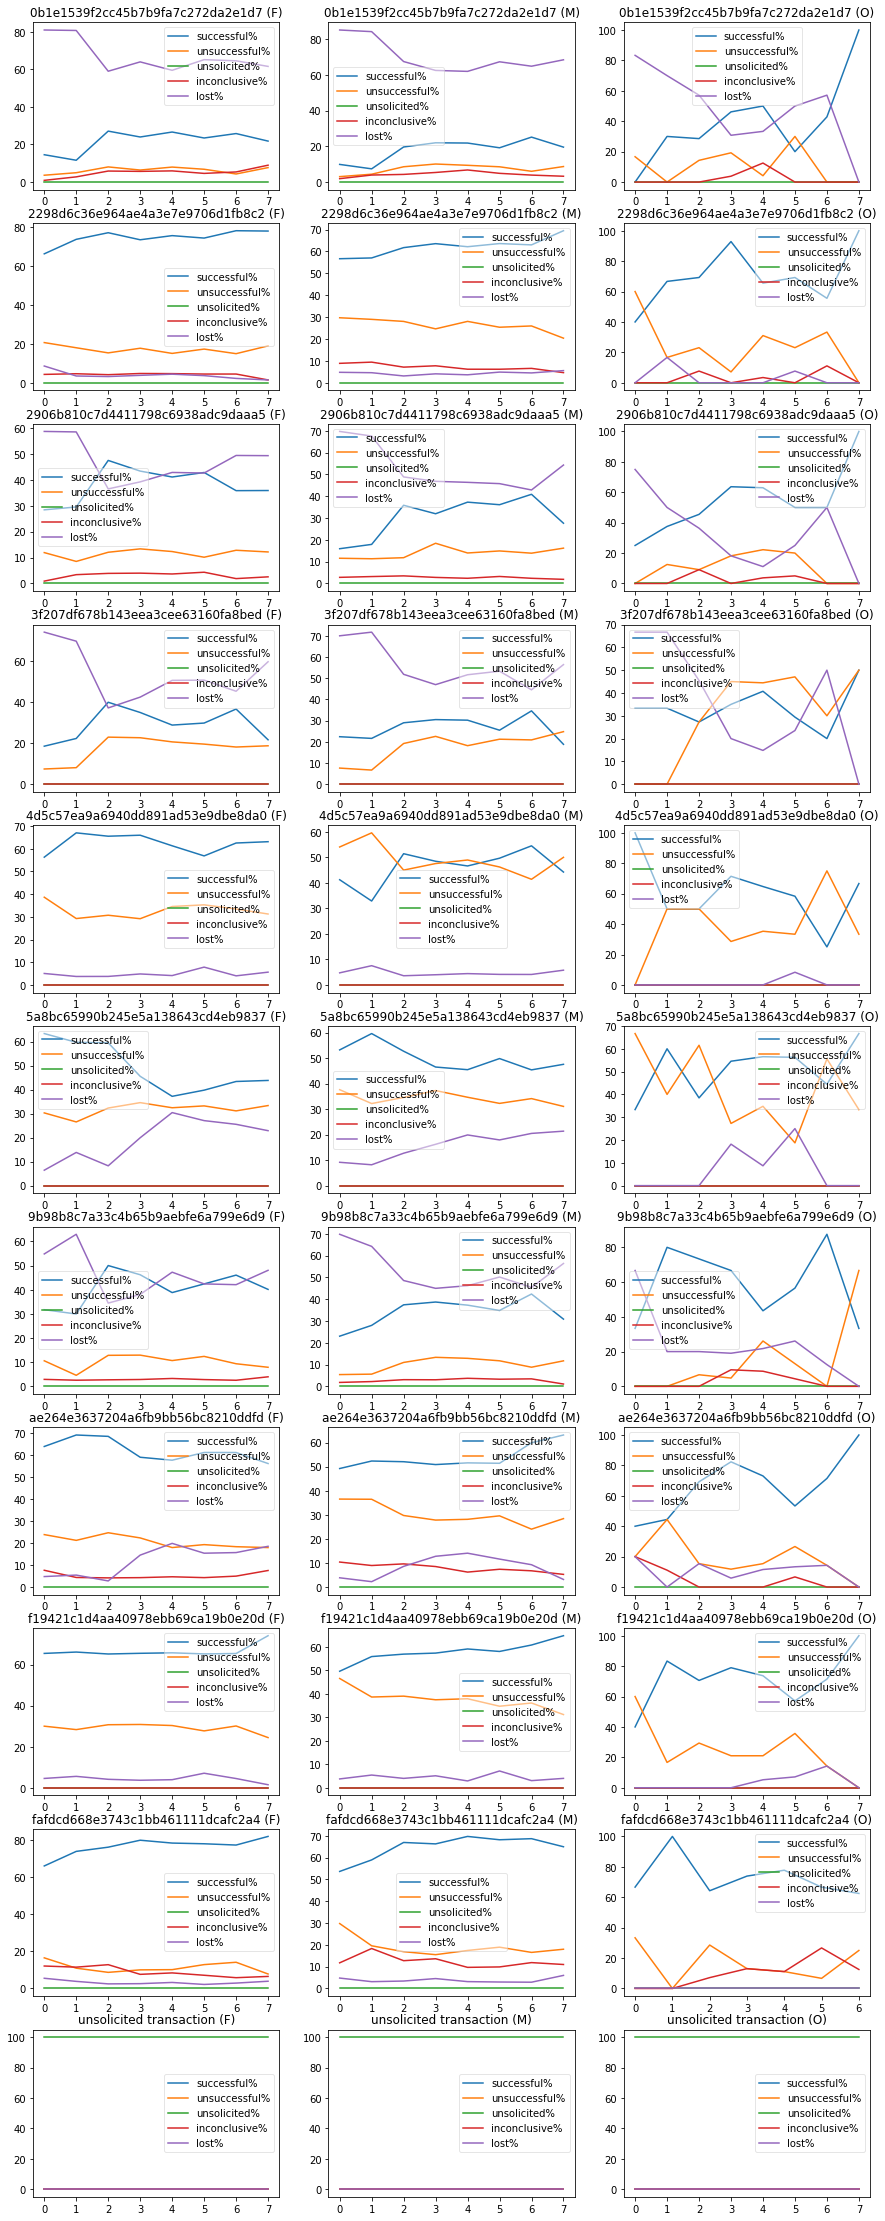

In [171]:
n_gender = df_outcome_gender_age['gender'].nunique()
n_offer = df_outcome_gender_age['offer'].nunique()
i_plot = 0
plt.figure(figsize=(15,40))
for offer in df_outcome_gender_age['offer'].unique():
    for gender in df_outcome_gender_age['gender'].unique():
        i_plot += 1
        plt.subplot(n_offer, n_gender, i_plot)
        df = df_outcome_gender_age[(df_outcome_gender_age['offer'] == offer) & (df_outcome_gender_age['gender'] == gender)]
        plt.plot(df['age bracket'], df['successful%'])
        plt.plot(df['age bracket'], df['unsuccessful%'])
        plt.plot(df['age bracket'], df['unsolicited%'])
        plt.plot(df['age bracket'], df['inconclusive%'])
        plt.plot(df['age bracket'], df['lost%'])
        plt.title(offer + ' (' + gender + ')')
        plt.legend(framealpha=0.5)  

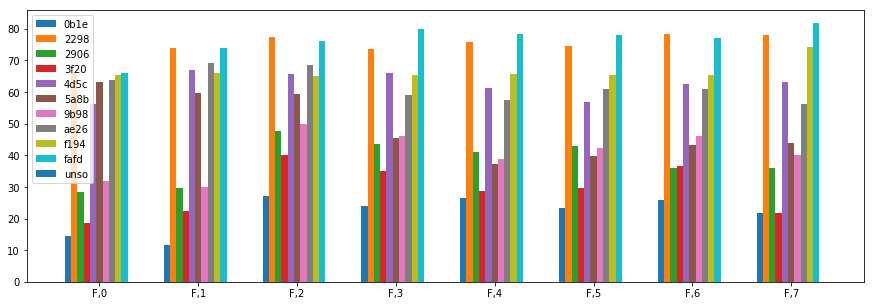

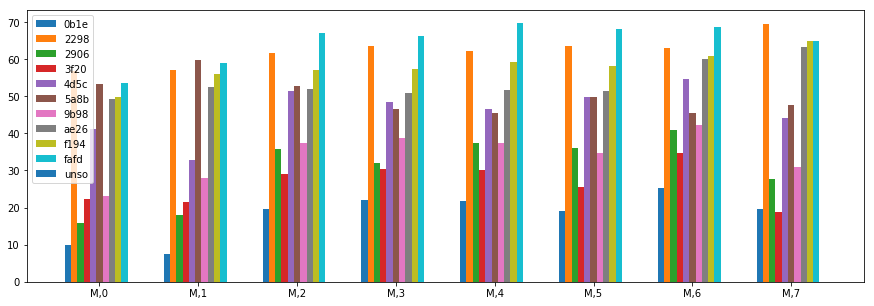

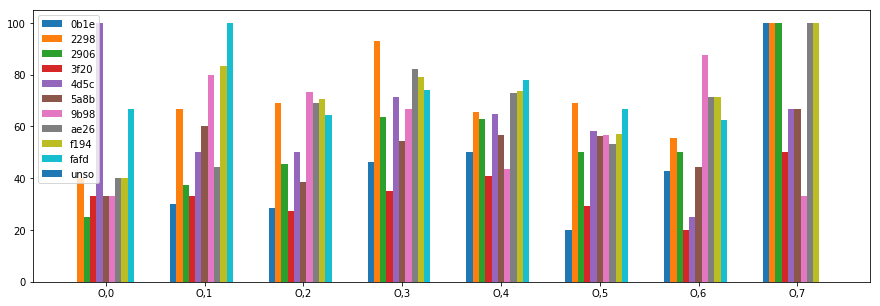

In [172]:
# make a chart of the percentage successful outcomes for each offer.
for gender in df_outcome_gender_age['gender'].unique():
    temp = df_outcome_gender_age[df_outcome_gender_age['gender'] == gender][['offer','age bracket','successful%']].pivot(index='offer', columns='age bracket')
    make_clustered_bar_chart(temp.values, [gender + ',' + s for s in temp.columns.levels[1]],
                             [s[0:4] for s in temp.index], temp.shape[0])

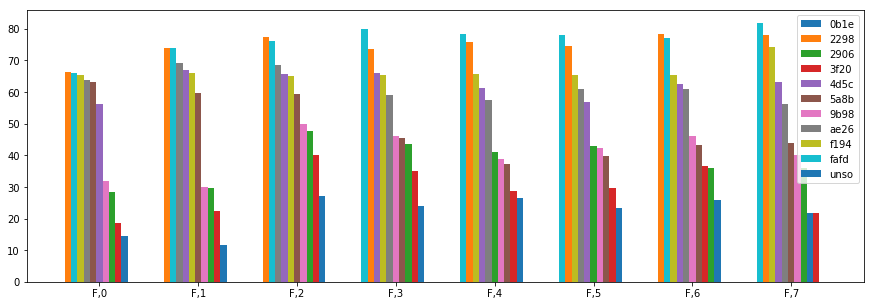

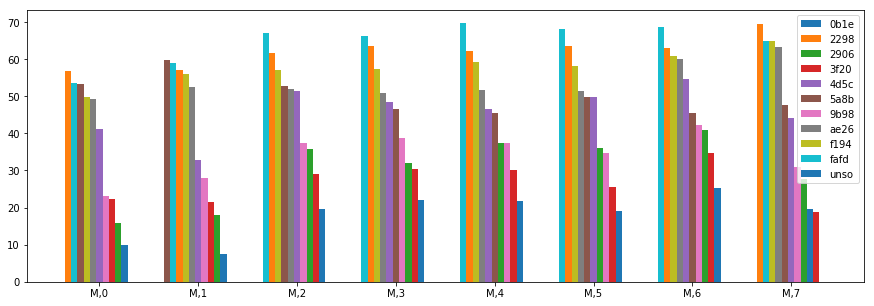

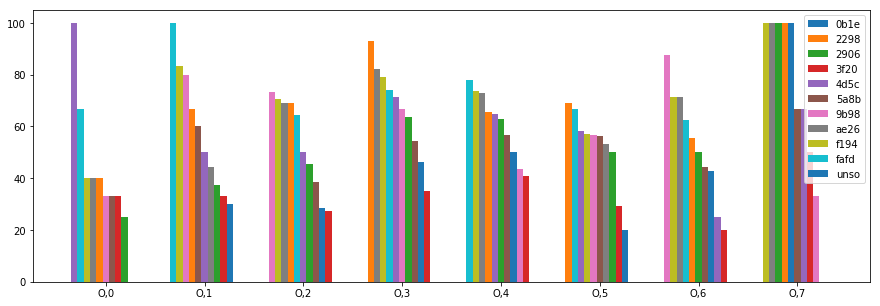

In [173]:
# make a chart of the percentage successful outcomes for each offer. sorted from most to least successful
# within each age bracket
for gender in df_outcome_gender_age['gender'].unique():
    temp = df_outcome_gender_age[df_outcome_gender_age['gender'] == gender][['offer','age bracket','successful%']].pivot(index='offer', columns='age bracket')
    make_sorted_clustered_bar_chart(temp.values, [gender + ',' + s for s in temp.columns.levels[1]],
                             [s[0:4] for s in temp.index], temp.shape[0])

In [174]:
# check the number of customers in the age brackets for the O gender
df_all_person_offer[df_all_person_offer['gender'] == 'O'].groupby('age bracket')['person'].count()

age bracket
0    100
1    205
2    285
3    415
4    487
5    329
6    138
7     49
Name: person, dtype: int64

The behavior for F and M genders versus income is as would be expected from preceeding charts of age only. 

The chart for O gender shows quite different behavior. **Bear in mind that the O gender group is much smaller than the F and M gender groups**. The highest income bracket contains only 56 customers in the O gender group, and it may be best to not draw conclusions regarding this demographic group. Generally, all offers (even **0b1e**) did much better in the higher income brackets than with other demographic groups.

### Display outcomes for each offer broken down by cluster

In [175]:
# what do the outcomes look like, broken down by cluster?
df_all_person_offer.groupby(['cluster'])[outcomes].sum()

,successful,unsuccessful,inconclusive,unsolicited,lost
cluster,,,,,
0.0,7795,2711,396,14191,3981
1.0,8608,7721,1209,19459,6683
2.0,6550,2544,408,16353,3071
3.0,525,218,29,1092,144
4.0,8454,1696,262,20696,3496


In [176]:
# convert the numbers to percentages
df_outcome_cluster = display_outcomes_by_group(df_all_person_offer, ['offer', 'cluster'])

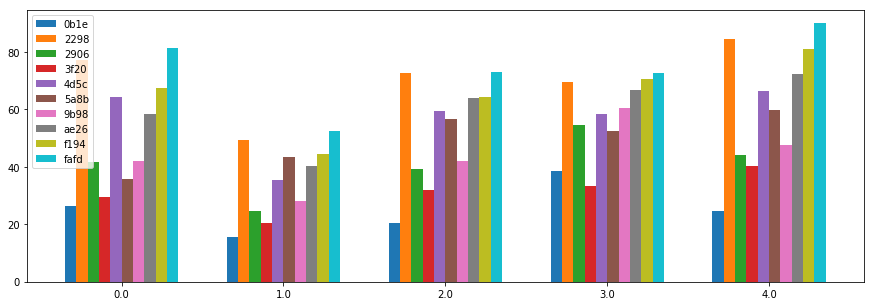

In [177]:
# make a chart of the percentage successful outcomes for each offer.
temp = df_outcome_cluster.drop(index='unsolicited transaction').unstack(level='offer')['successful%'].transpose()
make_clustered_bar_chart(temp.values, temp.columns, [s[0:4] for s in temp.index], len(temp.index))

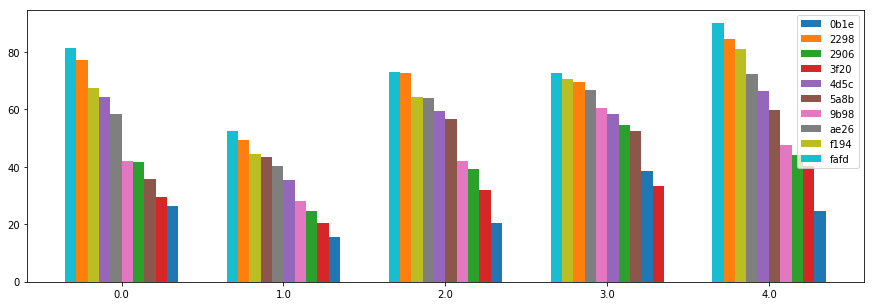

In [178]:
# make a chart of the percentage successful outcomes for each offer
# sorted from most to least successful within each cluster
temp = df_outcome_cluster.drop(index='unsolicited transaction').unstack(level='offer')['successful%'].transpose()
make_sorted_clustered_bar_chart(temp.values, temp.columns, [s[0:4] for s in temp.index], len(temp.index))

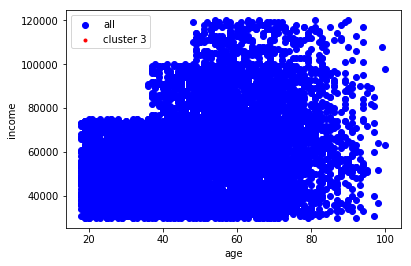

In [179]:
# how do the clusters overlay the profile data?
gender = 'M'
cluster = 3
x_var = 'age'
y_var = 'income'
plt.scatter(profile[profile['gender'] == gender][x_var], profile[profile['gender'] == gender][y_var], marker='o', color='blue', label='all')
plt.scatter(profile[(profile['gender'] == gender) & (profile['cluster'] == cluster)][x_var], profile[(profile['gender'] == gender) & (profile['cluster'] == cluster)][y_var], marker='.', color='red', label='cluster ' + str(cluster))
plt.legend()
plt.xlabel(x_var)
plt.ylabel(y_var);

In [180]:
km_results.iloc[8][2]

array([[ -1.18775828e+00,  -6.68518629e-01,   8.64526971e-01,
         -8.39527729e-01,  -1.20447624e-01,   4.81499669e-01],
       [  1.61267517e-01,   5.40132576e-02,  -1.15670191e+00,
          1.19114589e+00,  -1.20447624e-01,  -1.22514691e+00],
       [  4.26790167e-04,  -9.80321224e-02,  -1.15670191e+00,
         -8.39527729e-01,   8.30236384e+00,   8.47346723e-02],
       [ -5.07909537e-01,  -6.16663194e-01,   8.64526971e-01,
         -8.39527729e-01,  -1.20447624e-01,  -1.94592833e+00],
       [  5.87498191e-01,  -7.96939108e-01,   8.64526971e-01,
         -8.39527729e-01,  -1.20447624e-01,   4.81381569e-01],
       [ -9.90517731e-01,  -5.48838143e-01,  -1.15670191e+00,
          1.19114589e+00,  -1.20447624e-01,   3.48057247e-01],
       [  3.53728865e-01,   8.36174499e-01,   8.64526971e-01,
         -8.39527729e-01,  -1.20447624e-01,   6.42928789e-01],
       [  5.32558661e-01,   1.44511927e+00,  -1.15670191e+00,
          1.19114589e+00,  -1.20447624e-01,   1.29724167e-01],


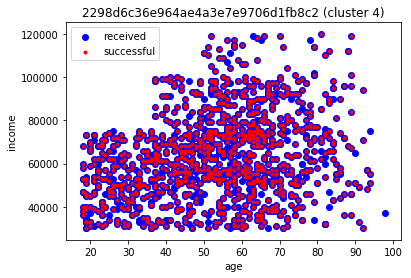

In [181]:
# plot all cluster points and cluster points for specified outcome for an offer
cluster = 4
x_var = 'age'
y_var = 'income'
offer = np.sort(all_offers_lst)[1]
outcome = 'successful'

plt.scatter(df_all_person_offer[(df_all_person_offer['offer'] == offer) & (df_all_person_offer['cluster'] == cluster)][x_var],
            df_all_person_offer[(df_all_person_offer['offer'] == offer) & (df_all_person_offer['cluster'] == cluster)][y_var],
            color='blue', marker='o', label='received')
plt.scatter(df_all_person_offer[(df_all_person_offer['offer'] == offer) & (df_all_person_offer[outcome] == 1) & (df_all_person_offer['cluster'] == cluster)][x_var],
            df_all_person_offer[(df_all_person_offer['offer'] == offer) & (df_all_person_offer[outcome] == 1) & (df_all_person_offer['cluster'] == cluster)][y_var],
            color='red', marker='.', label=outcome)


plt.legend()
plt.title(offer + ' (cluster ' + str(cluster) + ')')
plt.xlabel(x_var)
plt.ylabel(y_var);

### Take a look at how the categorization overlays against the clusters suggested by the PCA performed earlier.

Inspecting the loadings, PC1 and PC3 provide the best differentiation based on age and income. If the PC3 score is plotted on the y-axis and the PC1 score on the x-axis, then:
1. Lower left has high income
2. Upper left has high age
3. Lower right has low age
4. Upper right has low income.

In [182]:
def plot_outcome_and_all_persons_PC(df_all, df_outcome, offers, genders, outcome='successful', pc_x=0, pc_y=1):
    '''
    '''
    n_gender = len(genders)
    n_offer = len(offers)
    i = 0

    plt.figure(figsize=(20,70))        

    for offer in offers:
        for gender in genders:
            i += 1
            scores = pca.transform(sc.transform(df_all[(df_all[gender] == 1)][features]))
        
            X_outcome = df_outcome[(df_outcome['offer'] == offer) & (df_outcome[gender] == 1) & 
                                         (df_outcome[outcome] == 1)][features].dropna(axis=0).copy()
            if X_outcome.shape[0] > 0:
                X_outcome_scaled = sc.transform(X_outcome)
                scores_outcome = pca.transform(X_outcome_scaled)
                plt.subplot(n_offer, n_gender, i)
                plt.scatter(scores[:,pc_x], scores[:,pc_y], marker='o', color='blue', label='all persons')
                plt.scatter(scores_outcome[:,pc_x], scores_outcome[:,pc_y], marker='.', color='red', label=outcome)
                plt.legend()
                plt.xlabel('PC' + str(pc_x))
                plt.ylabel('PC' + str(pc_y))
                plt.title(offer + ' (' + gender + ')');

In [183]:
#plot_outcome_and_all_persons_PC(df_profile_groups, df_all_person_offer, portfolio['id'].unique(), 
#                             profile[~profile['gender'].isna()]['gender'].unique(), outcome='successful', pc_x=0, pc_y=2)

### Take a look at how the categorization overlays against the data for all persons.

In [184]:
def plot_outcome_and_all_persons(df_all, df_outcome, offers, genders, outcome='successful'):
    '''
    '''
    n_gender = len(genders)
    n_offer = len(offers)
    i = 0

    plt.figure(figsize=(20,70))        

    for offer in offers:
        for gender in genders:
            i += 1
            df = df_outcome[(df_outcome['offer'] == offer) & (df_outcome[gender] == 1) & (df_outcome[outcome] == 1)]
            if df.shape[0] > 0:
                plt.subplot(n_offer, n_gender, i)
                plt.scatter(df_all[df_all[gender] == 1]['age'].dropna(), df_all[df_all[gender] == 1]['income'].dropna(), 
                            marker='o', color='blue', label='all persons')
                plt.scatter(df['age'], df['income'], marker='.', color='red', label=outcome)
                plt.legend()
                plt.xlabel('age')
                plt.ylabel('income')
                plt.title(offer + ' (' + gender + ')');

In [185]:
#plot_outcome_and_all_persons(df_profile_groups, df_all_person_offer,portfolio['id'].unique(), 
#                             profile[~profile['gender'].isna()]['gender'].unique(), 
#                             outcome='successful')

# MODELING STARTS HERE

In [186]:
#from sklearn.preprocessing import StandardScaler
#from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
#from sklearn.tree import DecisionTreeClassifier
#from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, accuracy_score

#import scipy

#random_state = 99
#test_size = 0.5

#####['roc_auc','accuracy','balanced_accuracy','average_precision','f1','f1_weighted']

#sc_X = StandardScaler()

#dtc_vary_params = {'criterion': ['gini','entropy'],
#                   'splitter': ['random','best'],
#                   'max_depth': [3,4,5,6,7,8,9],
#                   'min_samples_leaf': [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24],
#                   'class_weight': ['balanced',None] 
#                  }

#scoring = 'recall'

# grid search set up. select grid search or randomize search by commenting the appropriate statement
#dtc = RandomizedSearchCV(estimator=DecisionTreeClassifier(random_state=random_state), 
#                            param_distributions=dtc_vary_params, scoring=scoring, n_iter=1000, random_state=18)
#dtc = GridSearchCV(estimator=DecisionTreeClassifier(random_state=random_state), param_grid=dtc_vary_params, scoring=scoring)


In [187]:
outcomes

['successful', 'unsuccessful', 'inconclusive', 'unsolicited', 'lost']

In [188]:
features

['age', 'income', 'M', 'F', 'O', 'became_member_year']

In [189]:
#DELETE
#df_model_data = df_all_person_offer[df_all_person_offer['offer'].isin(all_offers_lst)][['offer','cluster']+outcomes+features].dropna()

In [190]:
#DELETE
#df_model_data.head()

In [243]:
def tune_classifier(clf, df_all_person_offer, offer_lst, outcome, features, drop_features_from_model, parameters, scoring='recall',
                     test_size=0.25, random_state=99):
    
    from sklearn.preprocessing import StandardScaler
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import confusion_matrix

#    metric = 'test set ' + scoring

    df_models = pd.DataFrame()
    sc_X = StandardScaler()
    # loop through the offers
    for offers in tqdm(offer_lst):
        # select X and y data for the offer
        X_model = df_all_person_offer[df_all_person_offer['offer'].isin(offers)][features]
        y_model = df_all_person_offer[df_all_person_offer['offer'].isin(offers)][outcome]
        # split the data into training and test sets
        X_train, X_test, y_train, y_test = train_test_split(X_model, y_model, test_size=test_size, random_state=random_state)
        # scale the X data. y data is not scaled since the classifier expects 0/1
        X_train_scaled = sc_X.fit_transform(X_train.drop(columns=drop_features_from_model))
        X_test_scaled = sc_X.transform(X_test.drop(columns=drop_features_from_model))
        # search for optimal hyperparameters
        tuned_clf = GridSearchCV(estimator=clf, param_grid=parameters, scoring=scoring)
        tuned_clf.fit(X_train_scaled, y_train)
        
        cm = confusion_matrix(y_test, tuned_clf.predict(X_test_scaled))
        # this will not work if there is more than one label
        tn = cm[0,0]
        fp = cm[0,1]
        fn = cm[1,0]
        tp = cm[1,1]
        
        # make a comma-separated string with all the offers
        l = ''
        for o in offers:
            l = l + o + ','
        l = l[0:-1]
        
        # add optimal hyperparameters to data frame
#        df_models = df_models.append({**{'offer':l, 'tn':tn, 'tp':tp, 'fn':fn, 'fp':fp, 'target': scoring, **tuned_clf.best_params_},
#                                     **{'best_fit_classifier': tuned_clf.best_estimator_}},
#                                    ignore_index=True)
        
        df_models = df_models.append({**{'offer':l, 'tn':tn, 'tp':tp, 'fn':fn, 'fp':fp, 'target': scoring, **tuned_clf.best_params_},
                                     **{'best_fit_classifier': tuned_clf.best_estimator_},
                                     **{'standard_scaler_X': sc_X},
                                     **{'X_test':X_test},
                                     **{'y_test':y_test}},
                                    ignore_index=True)
        
    # reorder columns for better presentation
    c = list(df_models.columns)
    c.pop(c.index('offer'))
    c.pop(c.index('tp'))
    c.pop(c.index('tn'))
    c.pop(c.index('fp'))
    c.pop(c.index('fn'))
    c.pop(c.index('target'))
    c.pop(c.index('best_fit_classifier'))
    c = ['offer','target','tn','fp','fn','tp'] + c + ['best_fit_classifier']
    df_models = df_models[c]
    
    df_models[['tp','tn','fp','fn']] = df_models[['tp','tn','fp','fn']].astype(int)
    df_models['precision'] = df_models['tp'] / (df_models['tp'] + df_models['fp'])
    df_models['recall'] = df_models['tp'] / (df_models['tp'] + df_models['fn'])
    df_models['selectivity'] = df_models['tn'] / (df_models['tn'] + df_models['fp'])
    df_models['accuracy'] = (df_models['tp'] + df_models['tn']) / (df_models['tp'] + df_models['fp'] + df_models['tn'] + df_models['fn'])
    df_models['f1'] = 2 * df_models['precision'] * df_models['recall'] / (df_models['precision'] + df_models['recall'])
    
    return df_models

In [192]:
offer_lst = []
for o in all_offers_lst:
   offer_lst.append([o])
    
print(offer_lst)

[['ae264e3637204a6fb9bb56bc8210ddfd'], ['4d5c57ea9a6940dd891ad53e9dbe8da0'], ['3f207df678b143eea3cee63160fa8bed'], ['9b98b8c7a33c4b65b9aebfe6a799e6d9'], ['0b1e1539f2cc45b7b9fa7c272da2e1d7'], ['2298d6c36e964ae4a3e7e9706d1fb8c2'], ['fafdcd668e3743c1bb461111dcafc2a4'], ['5a8bc65990b245e5a138643cd4eb9837'], ['f19421c1d4aa40978ebb69ca19b0e20d'], ['2906b810c7d4411798c6938adc9daaa5']]


In [193]:
target_metric = 'accuracy'

In [194]:
# how well does decision tree perform?
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

dtree_vary_params = {'criterion': ['gini','entropy'],
                   'splitter': ['random','best'],
                   'max_depth': range(3,10),
                   'min_samples_leaf': range(2,25,2),
                   'class_weight': ['balanced',None] 
                  }

df_dtree = tune_classifier(DecisionTreeClassifier(random_state=99), df_all_person_offer.dropna(), 
                offer_lst, 'successful', features, [], dtree_vary_params, target_metric)

100%|██████████| 10/10 [01:58<00:00, 11.81s/it]


In [195]:
df_dtree

,offer,target,tn,fp,fn,tp,class_weight,criterion,max_depth,min_samples_leaf,splitter,best_fit_classifier,precision,recall,selectivity,accuracy,f1
0,ae264e3637204a6fb9bb56bc8210ddfd,accuracy,411,324,240,696,None,gini,9.0,22.0,random,"DecisionTreeClassifier(class_weight=None, crit...",0.682353,0.743590,0.559184,0.662478,0.711656
1,4d5c57ea9a6940dd891ad53e9dbe8da0,accuracy,447,302,259,641,None,gini,5.0,22.0,random,"DecisionTreeClassifier(class_weight=None, crit...",0.679745,0.712222,0.596796,0.659794,0.695605
2,3f207df678b143eea3cee63160fa8bed,accuracy,1148,30,453,34,None,entropy,6.0,12.0,best,"DecisionTreeClassifier(class_weight=None, crit...",0.531250,0.069815,0.974533,0.709910,0.123412
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,accuracy,891,146,413,222,None,entropy,4.0,2.0,best,"DecisionTreeClassifier(class_weight=None, crit...",0.603261,0.349606,0.859209,0.665670,0.442672
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,accuracy,1286,31,338,27,None,gini,7.0,14.0,best,"DecisionTreeClassifier(class_weight=None, crit...",0.465517,0.073973,0.976462,0.780618,0.127660
5,2298d6c36e964ae4a3e7e9706d1fb8c2,accuracy,223,293,168,980,None,gini,9.0,22.0,random,"DecisionTreeClassifier(class_weight=None, crit...",0.769835,0.853659,0.432171,0.722957,0.809583
6,fafdcd668e3743c1bb461111dcafc2a4,accuracy,184,296,124,1059,None,gini,8.0,24.0,random,"DecisionTreeClassifier(class_weight=None, crit...",0.781550,0.895182,0.383333,0.747444,0.834515
7,5a8bc65990b245e5a138643cd4eb9837,accuracy,647,225,396,393,None,gini,6.0,10.0,best,"DecisionTreeClassifier(class_weight=None, crit...",0.635922,0.498099,0.741972,0.626129,0.558635
8,f19421c1d4aa40978ebb69ca19b0e20d,accuracy,283,363,152,846,None,gini,6.0,14.0,random,"DecisionTreeClassifier(class_weight=None, crit...",0.699752,0.847695,0.438080,0.686740,0.766652
9,2906b810c7d4411798c6938adc9daaa5,accuracy,922,156,339,241,None,entropy,5.0,16.0,best,"DecisionTreeClassifier(class_weight=None, crit...",0.607053,0.415517,0.855288,0.701448,0.493347


In [196]:
# how well does random forest perform?
from sklearn.ensemble import RandomForestClassifier

rf_vary_params = {'criterion': ['gini','entropy'], # default='gini'
#                  'n_estimators': [100,200,300,400], # default=100
#                  'min_samples_split': [2,5,8], # default=2
                  'max_depth': range(2,10,2), # default=None
                  'min_samples_leaf': range(5,21,2), # default=1
                  'class_weight': ['balanced',None] # default=None
                 }

df_rforest = tune_classifier(RandomForestClassifier(random_state=99), df_all_person_offer.dropna(), 
                offer_lst, 'successful', features, [], rf_vary_params, target_metric)

100%|██████████| 10/10 [02:14<00:00, 13.43s/it]


In [197]:
df_rforest

,offer,target,tn,fp,fn,tp,class_weight,criterion,max_depth,min_samples_leaf,best_fit_classifier,precision,recall,selectivity,accuracy,f1
0,ae264e3637204a6fb9bb56bc8210ddfd,accuracy,377,358,190,746,None,gini,8.0,13.0,"(DecisionTreeClassifier(class_weight=None, cri...",0.675725,0.797009,0.512925,0.672053,0.731373
1,4d5c57ea9a6940dd891ad53e9dbe8da0,accuracy,446,303,238,662,None,entropy,6.0,9.0,"(DecisionTreeClassifier(class_weight=None, cri...",0.686010,0.735556,0.595461,0.671922,0.709920
2,3f207df678b143eea3cee63160fa8bed,accuracy,1138,40,440,47,None,gini,8.0,13.0,"(DecisionTreeClassifier(class_weight=None, cri...",0.540230,0.096509,0.966044,0.711712,0.163763
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,accuracy,887,150,403,232,None,entropy,8.0,17.0,"(DecisionTreeClassifier(class_weight=None, cri...",0.607330,0.365354,0.855352,0.669258,0.456244
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,accuracy,1302,15,351,14,None,entropy,8.0,15.0,"(DecisionTreeClassifier(class_weight=None, cri...",0.482759,0.038356,0.988610,0.782402,0.071066
5,2298d6c36e964ae4a3e7e9706d1fb8c2,accuracy,208,308,158,990,None,entropy,8.0,19.0,"(DecisionTreeClassifier(class_weight=None, cri...",0.762712,0.862369,0.403101,0.719952,0.809485
6,fafdcd668e3743c1bb461111dcafc2a4,accuracy,143,337,76,1107,None,gini,6.0,17.0,"(DecisionTreeClassifier(class_weight=None, cri...",0.766620,0.935757,0.297917,0.751654,0.842786
7,5a8bc65990b245e5a138643cd4eb9837,accuracy,622,250,346,443,None,gini,6.0,11.0,"(DecisionTreeClassifier(class_weight=None, cri...",0.639250,0.561470,0.713303,0.641180,0.597841
8,f19421c1d4aa40978ebb69ca19b0e20d,accuracy,305,341,165,833,None,gini,6.0,5.0,"(DecisionTreeClassifier(class_weight=None, cri...",0.709540,0.834669,0.472136,0.692214,0.767035
9,2906b810c7d4411798c6938adc9daaa5,accuracy,982,96,427,153,None,gini,6.0,7.0,"(DecisionTreeClassifier(class_weight=None, cri...",0.614458,0.263793,0.910946,0.684560,0.369119


In [198]:
# how well does logistic classification perform?
from sklearn.linear_model import LogisticRegression

log_vary_params = {'penalty':['l1','l2'],
                   'class_weight': ['balanced',None]
                  }

df_logreg = tune_classifier(LogisticRegression(random_state=99, max_iter=200, solver='saga'), df_all_person_offer.dropna(), 
                offer_lst, 'successful', features, [], log_vary_params, target_metric)

100%|██████████| 10/10 [00:03<00:00,  2.80it/s]


In [199]:
df_logreg

,offer,target,tn,fp,fn,tp,class_weight,penalty,best_fit_classifier,precision,recall,selectivity,accuracy,f1
0,ae264e3637204a6fb9bb56bc8210ddfd,accuracy,443,292,280,656,balanced,l2,"LogisticRegression(C=1.0, class_weight='balanc...",0.691983,0.700855,0.602721,0.657690,0.696391
1,4d5c57ea9a6940dd891ad53e9dbe8da0,accuracy,471,278,288,612,None,l1,"LogisticRegression(C=1.0, class_weight=None, d...",0.687640,0.680000,0.628838,0.656762,0.683799
2,3f207df678b143eea3cee63160fa8bed,accuracy,1166,12,483,4,None,l2,"LogisticRegression(C=1.0, class_weight=None, d...",0.250000,0.008214,0.989813,0.702703,0.015905
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,accuracy,916,121,520,115,None,l2,"LogisticRegression(C=1.0, class_weight=None, d...",0.487288,0.181102,0.883317,0.616627,0.264064
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,accuracy,1316,1,363,2,None,l1,"LogisticRegression(C=1.0, class_weight=None, d...",0.666667,0.005479,0.999241,0.783591,0.010870
5,2298d6c36e964ae4a3e7e9706d1fb8c2,accuracy,161,355,91,1057,None,l2,"LogisticRegression(C=1.0, class_weight=None, d...",0.748584,0.920732,0.312016,0.731971,0.825781
6,fafdcd668e3743c1bb461111dcafc2a4,accuracy,168,312,92,1091,None,l2,"LogisticRegression(C=1.0, class_weight=None, d...",0.777619,0.922232,0.350000,0.757066,0.843774
7,5a8bc65990b245e5a138643cd4eb9837,accuracy,596,276,351,438,None,l2,"LogisticRegression(C=1.0, class_weight=None, d...",0.613445,0.555133,0.683486,0.622517,0.582834
8,f19421c1d4aa40978ebb69ca19b0e20d,accuracy,275,371,134,864,None,l2,"LogisticRegression(C=1.0, class_weight=None, d...",0.699595,0.865731,0.425697,0.692822,0.773847
9,2906b810c7d4411798c6938adc9daaa5,accuracy,971,107,490,90,None,l1,"LogisticRegression(C=1.0, class_weight=None, d...",0.456853,0.155172,0.900742,0.639928,0.231660


In [200]:
# how well does a neural network perform?
from sklearn.neural_network import MLPClassifier

mlp_vary_params = {'hidden_layer_sizes':[(200),(100,100),(200,200),(100,100,100),(50,50,50,50,50,50)]
                  }

df_mlp = tune_classifier(MLPClassifier(random_state=99, max_iter=200), df_all_person_offer.dropna(), 
                offer_lst, 'successful', features, [], mlp_vary_params, target_metric)

100%|██████████| 10/10 [03:12<00:00, 17.86s/it]


In [201]:
df_mlp

,offer,target,tn,fp,fn,tp,hidden_layer_sizes,best_fit_classifier,precision,recall,selectivity,accuracy,f1
0,ae264e3637204a6fb9bb56bc8210ddfd,accuracy,317,418,154,782,"(200, 200)","MLPClassifier(activation='relu', alpha=0.0001,...",0.651667,0.835470,0.431293,0.657690,0.732210
1,4d5c57ea9a6940dd891ad53e9dbe8da0,accuracy,437,312,215,685,200,"MLPClassifier(activation='relu', alpha=0.0001,...",0.687061,0.761111,0.583445,0.680412,0.722193
2,3f207df678b143eea3cee63160fa8bed,accuracy,1164,14,469,18,"(100, 100)","MLPClassifier(activation='relu', alpha=0.0001,...",0.562500,0.036961,0.988115,0.709910,0.069364
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,accuracy,870,167,382,253,"(50, 50, 50, 50, 50, 50)","MLPClassifier(activation='relu', alpha=0.0001,...",0.602381,0.398425,0.838959,0.671651,0.479621
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,accuracy,1294,23,347,18,"(100, 100, 100)","MLPClassifier(activation='relu', alpha=0.0001,...",0.439024,0.049315,0.982536,0.780024,0.088670
5,2298d6c36e964ae4a3e7e9706d1fb8c2,accuracy,190,326,127,1021,"(200, 200)","MLPClassifier(activation='relu', alpha=0.0001,...",0.757981,0.889373,0.368217,0.727764,0.818437
6,fafdcd668e3743c1bb461111dcafc2a4,accuracy,153,327,82,1101,"(100, 100)","MLPClassifier(activation='relu', alpha=0.0001,...",0.771008,0.930685,0.318750,0.754059,0.843355
7,5a8bc65990b245e5a138643cd4eb9837,accuracy,597,275,314,475,"(100, 100)","MLPClassifier(activation='relu', alpha=0.0001,...",0.633333,0.602028,0.684633,0.645394,0.617284
8,f19421c1d4aa40978ebb69ca19b0e20d,accuracy,268,378,128,870,"(100, 100)","MLPClassifier(activation='relu', alpha=0.0001,...",0.697115,0.871743,0.414861,0.692214,0.774711
9,2906b810c7d4411798c6938adc9daaa5,accuracy,874,204,325,255,"(100, 100, 100)","MLPClassifier(activation='relu', alpha=0.0001,...",0.555556,0.439655,0.810761,0.680941,0.490857


In [202]:
df_compare = df_dtree[['offer',target_metric]].merge(df_rforest[['offer',target_metric]], on='offer', suffixes=('_dt','_rf'))
df_compare = df_compare.merge(df_logreg[['offer',target_metric]], on='offer').rename(columns={target_metric:target_metric+'_log'})
df_compare = df_compare.merge(df_mlp[['offer',target_metric]], on='offer').rename(columns={target_metric:target_metric+'_mlp'})

In [203]:
df_compare

,offer,accuracy_dt,accuracy_rf,accuracy_log,accuracy_mlp
0,ae264e3637204a6fb9bb56bc8210ddfd,0.662478,0.672053,0.657690,0.657690
1,4d5c57ea9a6940dd891ad53e9dbe8da0,0.659794,0.671922,0.656762,0.680412
2,3f207df678b143eea3cee63160fa8bed,0.709910,0.711712,0.702703,0.709910
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.665670,0.669258,0.616627,0.671651
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.780618,0.782402,0.783591,0.780024
5,2298d6c36e964ae4a3e7e9706d1fb8c2,0.722957,0.719952,0.731971,0.727764
6,fafdcd668e3743c1bb461111dcafc2a4,0.747444,0.751654,0.757066,0.754059
7,5a8bc65990b245e5a138643cd4eb9837,0.626129,0.641180,0.622517,0.645394
8,f19421c1d4aa40978ebb69ca19b0e20d,0.686740,0.692214,0.692822,0.692214
9,2906b810c7d4411798c6938adc9daaa5,0.701448,0.684560,0.639928,0.680941


# GLOBAL MODEL

In [204]:
df_all_person_offer.head()

,person,received,offer,amount,difficulty,duration,reward,bogo,discount,informational,...,income,became_member_day,became_member_month,became_member_year,cluster,M,F,O,income bracket,age bracket
0,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.00,5.00,7,5,1.0,0.0,0.0,...,100000.0,9,5,2017,0.0,0,1,0,3,6
1,78afa995795e4d85b5d9ceeca43f5fef,168,5a8bc65990b245e5a138643cd4eb9837,0.01,0.01,3,0,0.0,0.0,1.0,...,100000.0,9,5,2017,0.0,0,1,0,3,6
2,78afa995795e4d85b5d9ceeca43f5fef,408,ae264e3637204a6fb9bb56bc8210ddfd,10.00,10.00,7,10,1.0,0.0,0.0,...,100000.0,9,5,2017,0.0,0,1,0,3,6
3,78afa995795e4d85b5d9ceeca43f5fef,504,f19421c1d4aa40978ebb69ca19b0e20d,0.00,5.00,5,5,1.0,0.0,0.0,...,100000.0,9,5,2017,0.0,0,1,0,3,6
4,78afa995795e4d85b5d9ceeca43f5fef,0,unsolicited transaction,17.78,0.00,0,0,NaN,NaN,NaN,...,100000.0,9,5,2017,0.0,0,1,0,3,6


In [205]:
features_global = ['age','income','M','F','O','became_member_year','bogo','discount','informational',
                   'difficulty','reward','duration','mobile','web','social','email','cluster']

In [206]:
labels_global = ['successful']

In [278]:
# how well does decision tree classification perform?
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

dtree_vary_params = {'criterion': ['gini','entropy'],
                   'splitter': ['random','best'],
                   'max_depth': range(3,10),
                   'min_samples_leaf': range(2,25,2),
                   'class_weight': ['balanced',None] 
                  }

df_global_dtree = tune_classifier(DecisionTreeClassifier(random_state=99), df_all_person_offer.dropna(), 
                [all_offers_lst], 'successful', features_global, ['cluster'], dtree_vary_params, target_metric)

100%|██████████| 1/1 [02:23<00:00, 143.17s/it]


In [279]:
df_global_dtree

,offer,target,tn,fp,fn,tp,X_test,class_weight,criterion,max_depth,min_samples_leaf,splitter,standard_scaler_X,y_test,best_fit_classifier,precision,recall,selectivity,accuracy,f1
0,"ae264e3637204a6fb9bb56bc8210ddfd,4d5c57ea9a694...",accuracy,6212,2503,2633,5278,age income M F O became_member...,balanced,gini,8.0,14.0,best,"StandardScaler(copy=True, with_mean=True, with...",23208 0 100346 1 45911 1 65663 ...,DecisionTreeClassifier(class_weight='balanced'...,0.678319,0.667172,0.712794,0.691086,0.672699


In [294]:
best_dtree_clf = df_global_dtree['best_fit_classifier'][0]
X_global_test = df_global_dtree['X_test'][0]
y_global_test = df_global_dtree['y_test'][0]
sc_X = df_global_dtree['standard_scaler_X'][0]

In [330]:
df_cluster = pd.DataFrame()

for cluster in np.sort(X_global_test['cluster'].unique()):
    # get X and y test sets for the selected cluster
    X_global_test_cluster = X_global_test[X_global_test['cluster'] == cluster]
    y_global_test_cluster = y_global_test.loc[X_global_test_cluster.index]

    # scale the X set
    X_global_test_cluster_scaled = sc_X.transform(X_global_test_cluster.drop(columns='cluster'))
    
    [tn,fp], [fn,tp] = confusion_matrix(y_global_test_cluster, best_dtree_clf.predict(X_global_test_cluster_scaled))

    df_cluster = df_cluster.append({'cluster': cluster, 'tn':tn, 'fp':fp, 'fn':fn, 'tp':tp}, ignore_index=True)
    
df_cluster['precision'] = df_cluster['tp'] / (df_cluster['tp'] + df_cluster['fp'])
df_cluster['recall'] = df_cluster['tp'] / (df_cluster['tp'] + df_cluster['fn'])
df_cluster['selectivity'] = df_cluster['tn'] / (df_cluster['tn'] + df_cluster['fp'])
df_cluster['accuracy'] = (df_cluster['tn'] + df_cluster['tp']) / (df_cluster['tn'] + df_cluster['tp'] + df_cluster['fp'] + df_cluster['fn'])
df_cluster['f1'] = 2 * df_cluster['precision'] * df_cluster['recall'] / (df_cluster['precision'] + df_cluster['recall'])
df_cluster[['cluster','fn','fp','tn','tp']] = df_cluster[['cluster','fn','fp','tn','tp']].astype(int)

In [331]:
df_cluster

,cluster,fn,fp,tn,tp,precision,recall,selectivity,accuracy,f1
0,0,571,569,1210,1373,0.707003,0.706276,0.680157,0.693795,0.706639
1,1,1214,706,3255,908,0.562577,0.427898,0.821762,0.684366,0.486081
2,2,467,535,943,1124,0.677517,0.706474,0.638024,0.673509,0.691692
3,3,50,40,57,85,0.680000,0.629630,0.587629,0.612069,0.653846
4,4,331,653,747,1788,0.732487,0.843794,0.533571,0.720375,0.784211
